# MeasureSoftGram 2021/02 - Analytics 

#### Date: 2021/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2021/02
##### Professor: Hilmer Neri

##### Members:

- Igor Batista Paiva
- Renan Cristyan
- Rhuan Queiroz
- Thiago Lopes

### LIBRARIES

In [244]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [245]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [246]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [247]:
jsons = glob('../analytics-raw-data/*.json') # add your path here

In [248]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = pd.concat([df, base_component_df], ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021.2-(.*?)-(.*?)-(.*?)-(.*?)-v(.*?).json", expand=True)

    df['repository'] = aux_df[2]

    df['version'] = aux_df[5]

    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [249]:
base_component_df = create_base_component_df(jsons)

In [250]:
base_component_df.head(20)

,metric,value,bestValue,filename,repository,version
0,duplicated_lines_density,0.0,True,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
1,functions,17,NaN,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
2,test_execution_time,534,NaN,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
3,test_failures,0,True,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
4,test_errors,0,True,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
5,security_rating,1.0,True,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
6,tests,22,NaN,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
7,files,5,NaN,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
8,complexity,64,NaN,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
9,ncloc,331,NaN,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0


#### Create dataframe per file

In [251]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

len(metric_list)

12

In [252]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'py')

        file_component_df['filename'] = os.path.basename(i)

        df = pd.concat([df, file_component_df], ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-v(.*?).json", expand=True)

    df['repository'] = aux_df[0]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [253]:
file_component_df = create_file_df(jsons)
file_component_df.repository.unique()

array(['fga-eps-mds-2021-2-MeasureSoftGram-CLI',
       'fga-eps-mds-2021-2-MeasureSoftGram-Core',
       'fga-eps-mds-2021-2-MeasureSoftGram-Service'], dtype=object)

#### Create dataframe per repository

In [254]:
# Example

cli_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2021-2-MeasureSoftGram-CLI']
service_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2021-2-MeasureSoftGram-Service']
core_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2021-2-MeasureSoftGram-Core']


In [255]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [256]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [257]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [258]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [259]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [260]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

##### Test coverage

In [261]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [262]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    #m4_list = []
    #m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        #m4_list.append(m3(version_df))
        #m5_list.append(m3(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               #'m4': m4_list,
                               #'m5': m5_list,
                               'm6': m6_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [263]:
cli_metrics = create_metrics_df(cli_df)
service_metrics = create_metrics_df(service_df)
core_metrics = create_metrics_df(core_df)


### Data visualization

- You must do this for each of your repositories

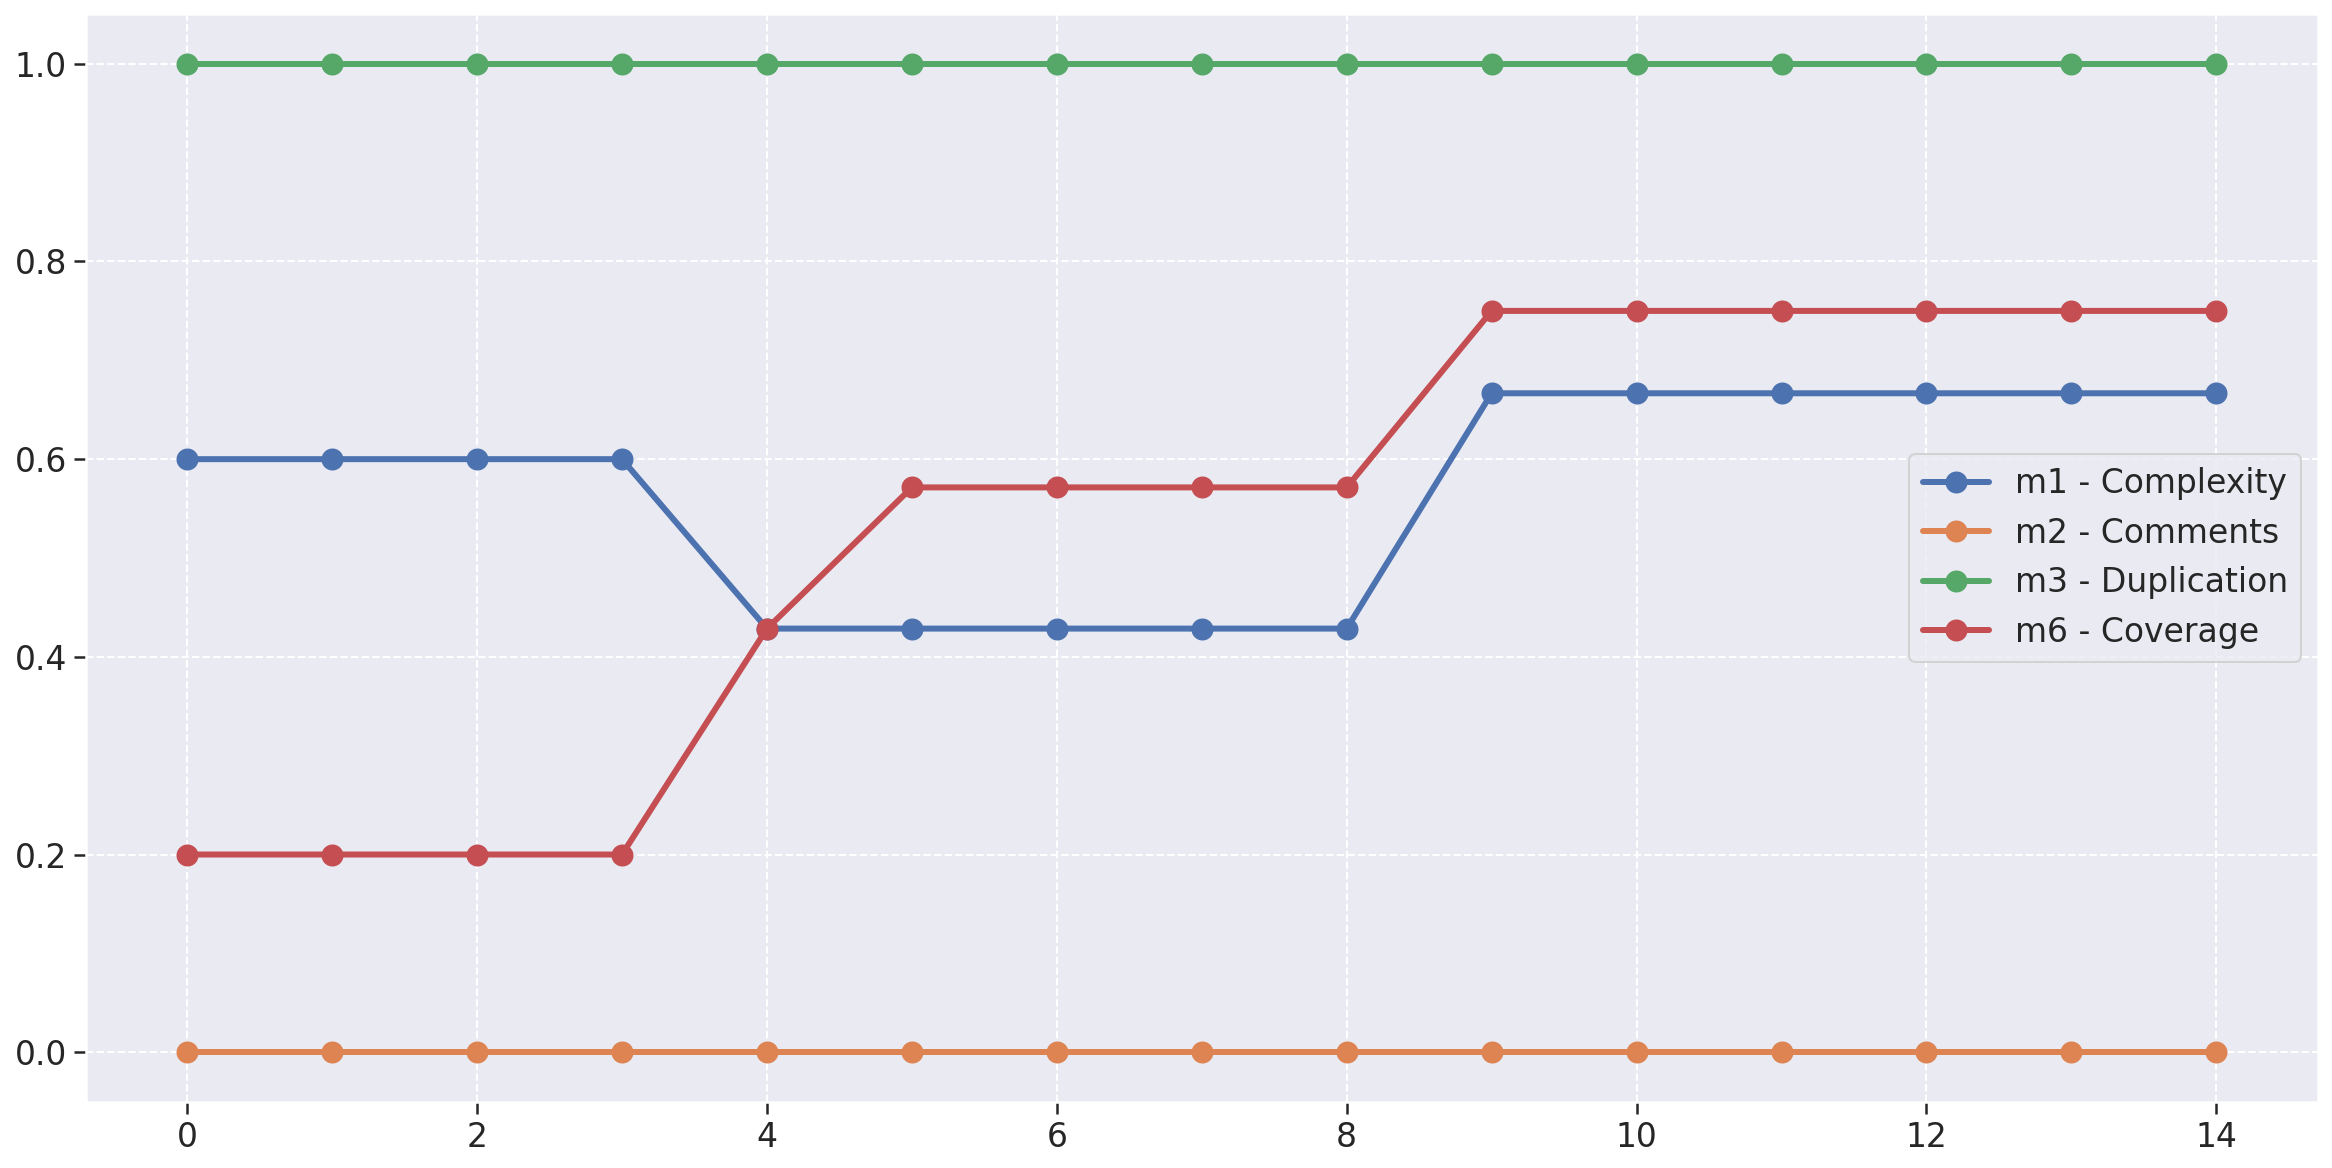

In [264]:
fig = plt.figure(figsize=(20, 10))

plt.plot(cli_metrics['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(cli_metrics['m2'], linewidth=3, marker='o', markersize=10, label="m2 - Comments")
plt.plot(cli_metrics['m3'], linewidth=3, marker='o', markersize=10, label="m3 - Duplication")
# plt.plot(cli_metrics['m4'], linewidth=3, marker='o', markersize=10, label="m4")
# plt.plot(cli_metrics['m5'], linewidth=3, marker='o', markersize=10, label="m5")
plt.plot(cli_metrics['m6'], linewidth=3, marker='o', markersize=10, label="m6 - Coverage")

plt.legend(loc='best')

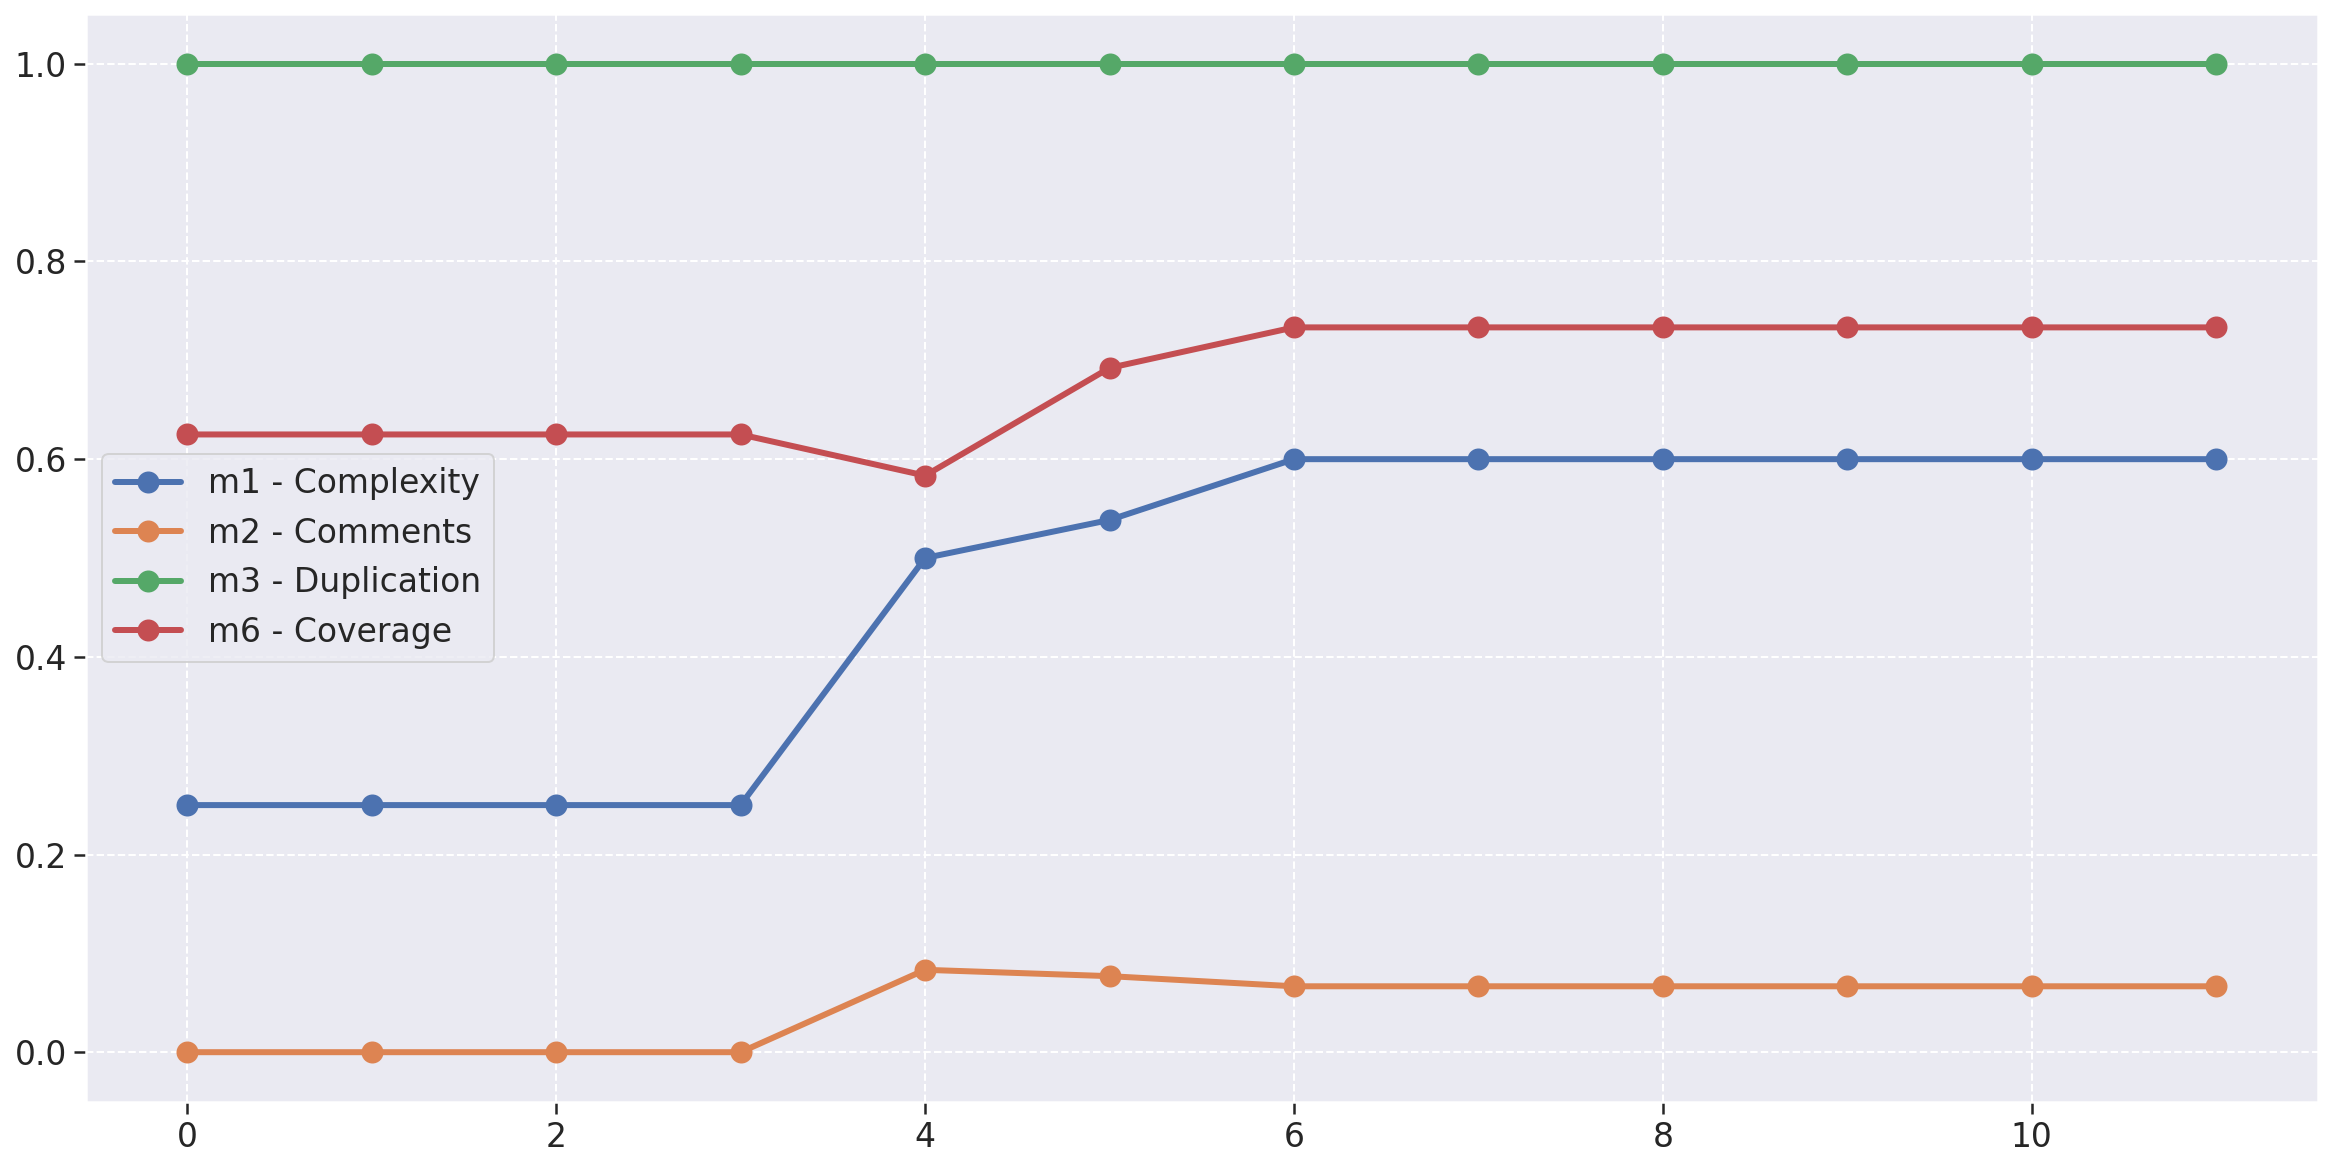

In [265]:
fig = plt.figure(figsize=(20, 10))

plt.plot(service_metrics['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(service_metrics['m2'], linewidth=3, marker='o', markersize=10, label="m2 - Comments")
plt.plot(service_metrics['m3'], linewidth=3, marker='o', markersize=10, label="m3 - Duplication")
# plt.plot(service_metrics['m4'], linewidth=3, marker='o', markersize=10, label="m4")
# plt.plot(service_metrics['m5'], linewidth=3, marker='o', markersize=10, label="m5")
plt.plot(service_metrics['m6'], linewidth=3, marker='o', markersize=10, label="m6 - Coverage")

plt.legend(loc='best')

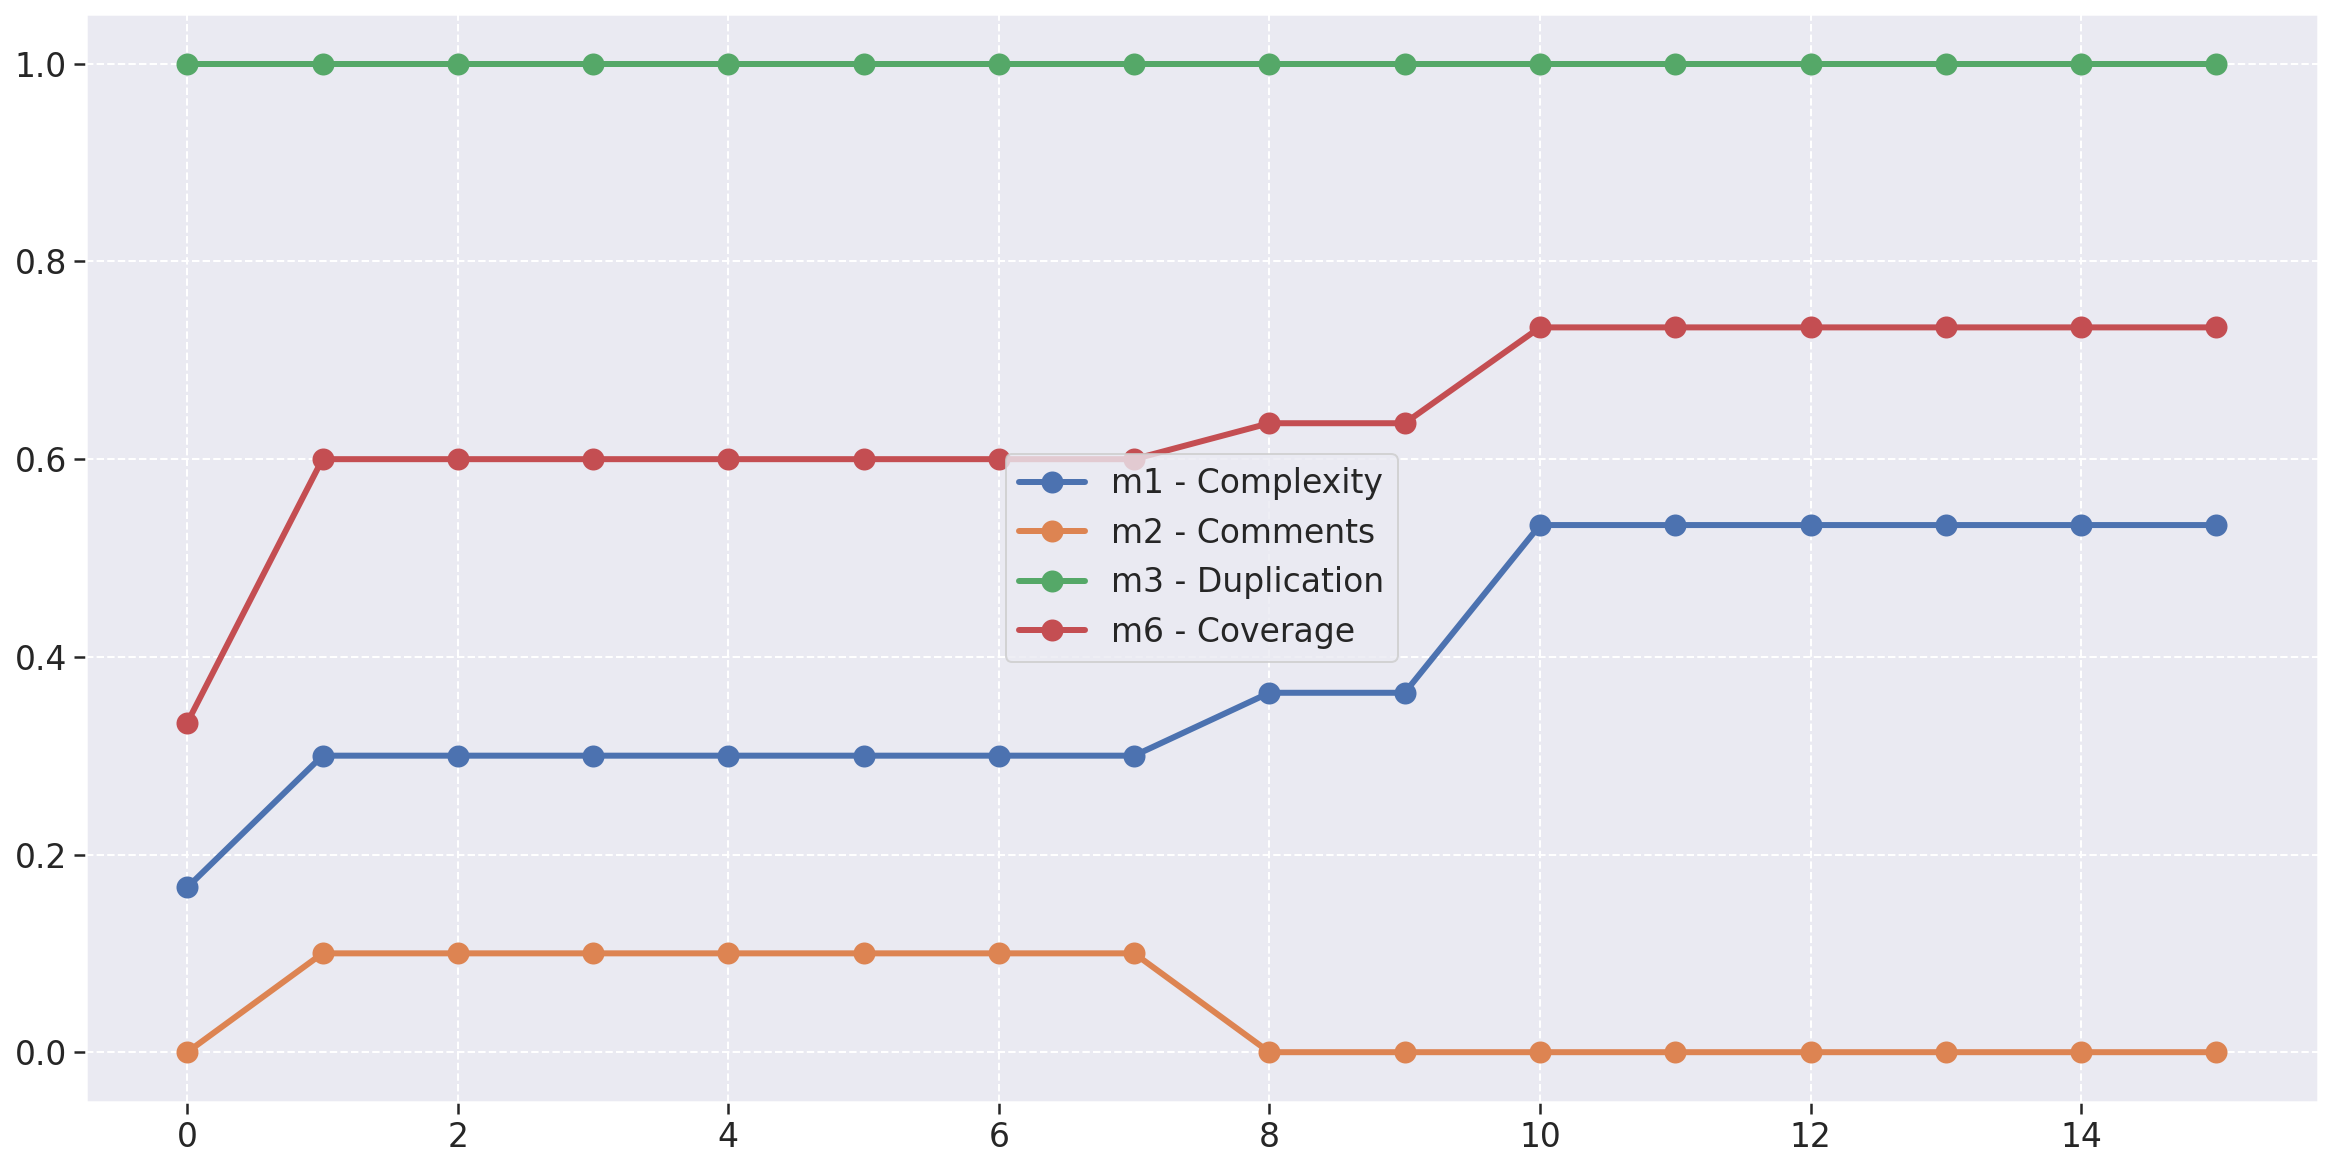

In [266]:
fig = plt.figure(figsize=(20, 10))

plt.plot(core_metrics['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(core_metrics['m2'], linewidth=3, marker='o', markersize=10, label="m2 - Comments")
plt.plot(core_metrics['m3'], linewidth=3, marker='o', markersize=10, label="m3 - Duplication")
# plt.plot(core_metrics['m4'], linewidth=3, marker='o', markersize=10, label="m4")
# plt.plot(core_metrics['m5'], linewidth=3, marker='o', markersize=10, label="m5")
plt.plot(core_metrics['m6'], linewidth=3, marker='o', markersize=10, label="m6 - Coverage")

plt.legend(loc='best')

### Sub characteristic aggregation

- You must do this for each of your repositories

In [267]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

cli_metrics['code_quality'] = ((cli_metrics['m1']*pm1) + (cli_metrics['m2']*pm2) + (cli_metrics['m3']*pm3)) * psc1
service_metrics['code_quality'] = ((service_metrics['m1']*pm1) + (service_metrics['m2']*pm2) + (service_metrics['m3']*pm3)) * psc1
core_metrics['code_quality'] = ((core_metrics['m1']*pm1) + (core_metrics['m2']*pm2) + (core_metrics['m3']*pm3)) * psc1

cli_metrics['testing_status'] = cli_metrics['m6'] * psc2
service_metrics['testing_status'] = service_metrics['m6'] * psc2
core_metrics['testing_status'] = core_metrics['m6'] * psc2


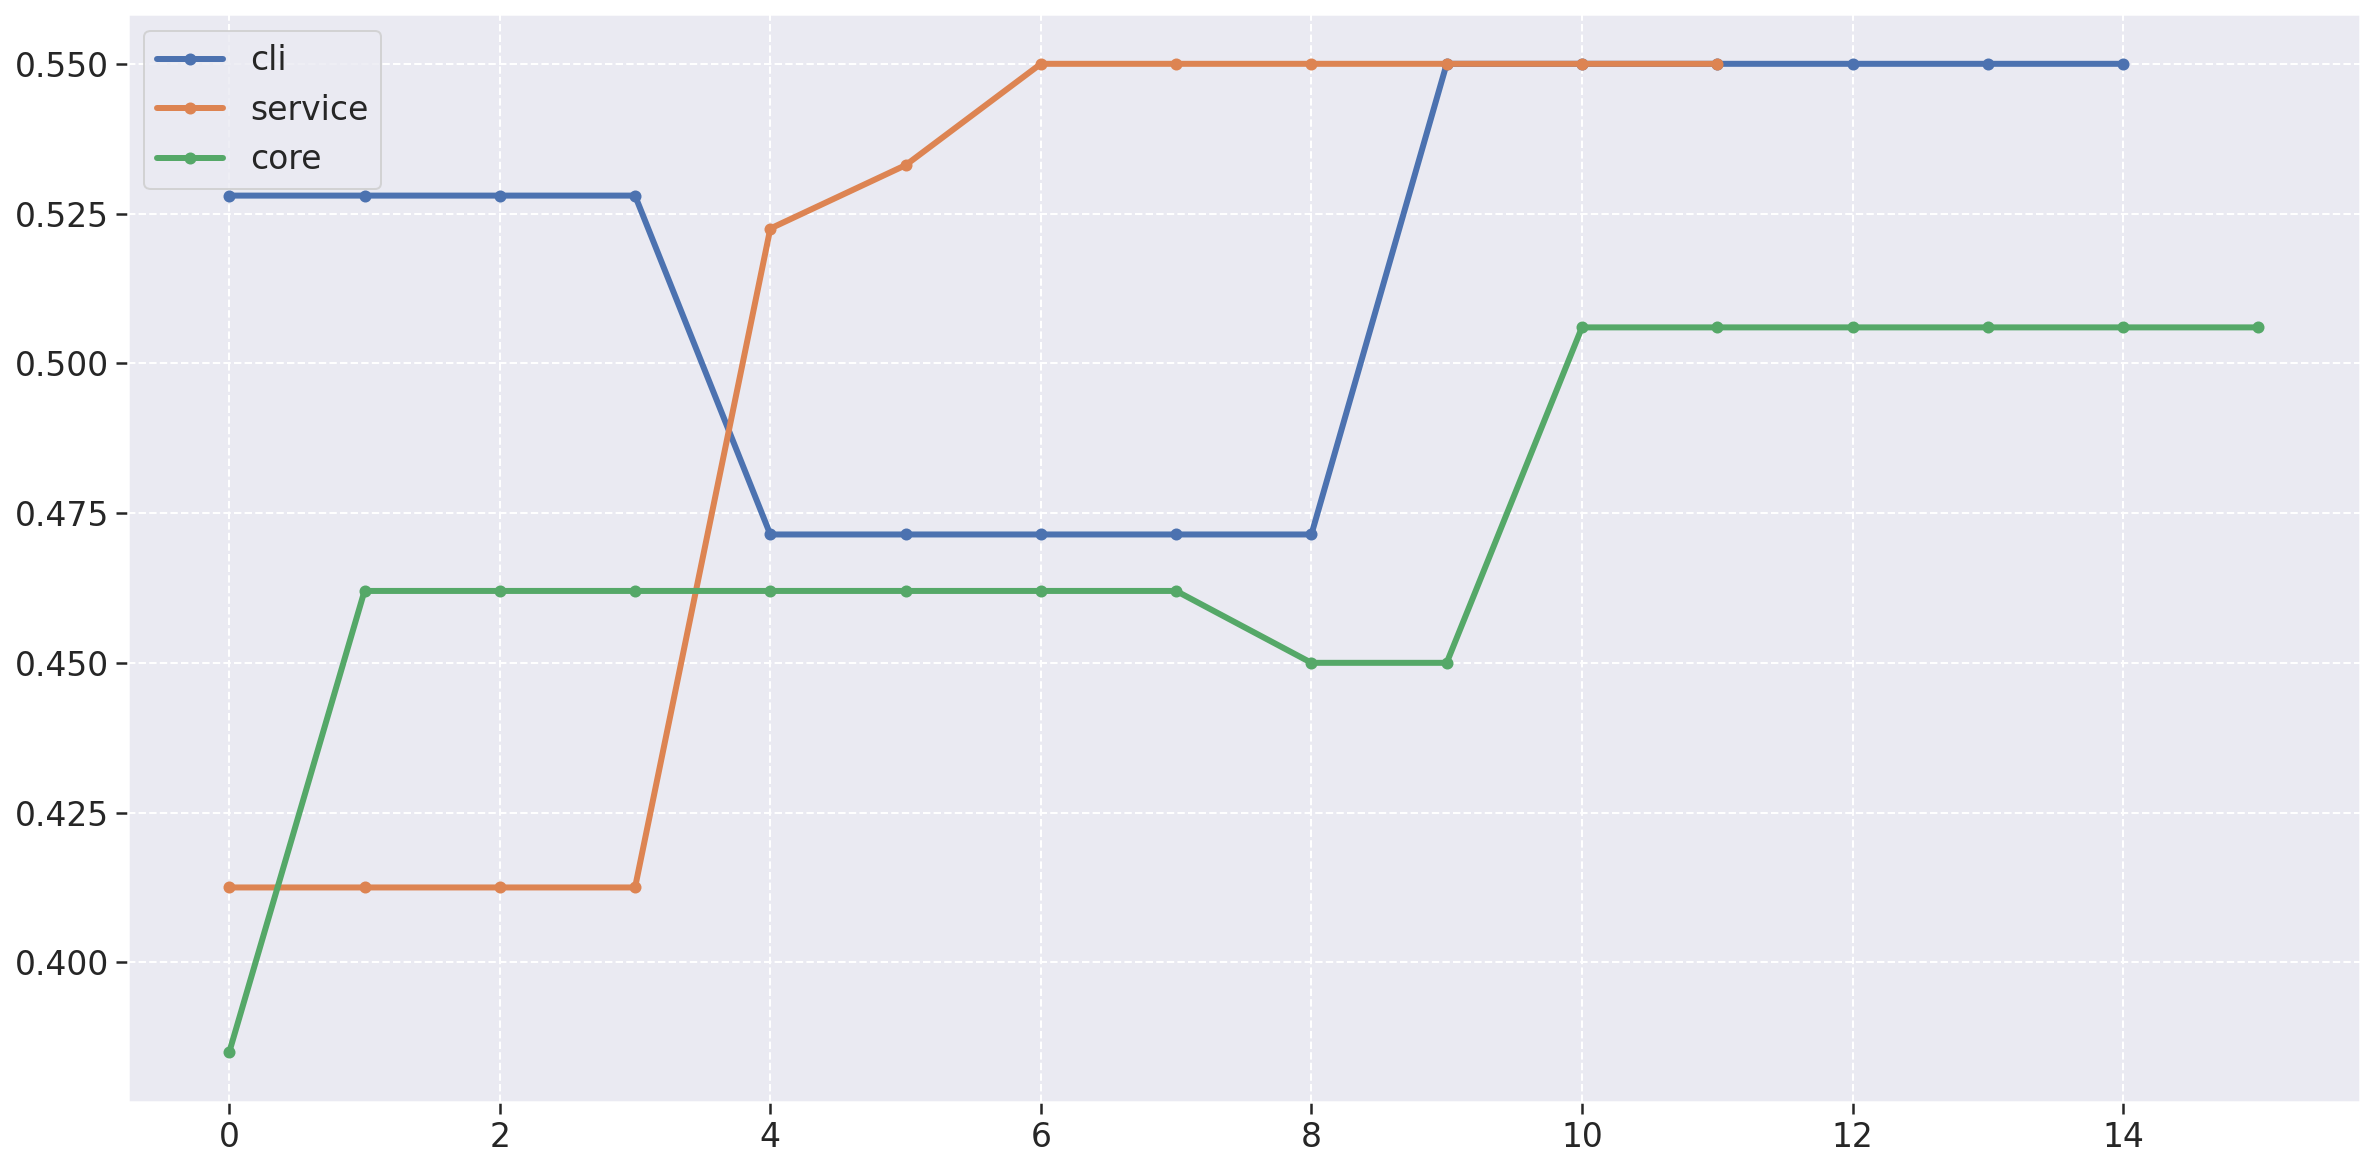

In [268]:
fig = plt.figure(figsize=(20, 10))


plt.plot(cli_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label="cli")
plt.plot(service_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label="service")
plt.plot(core_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label="core")

plt.legend(loc='best')


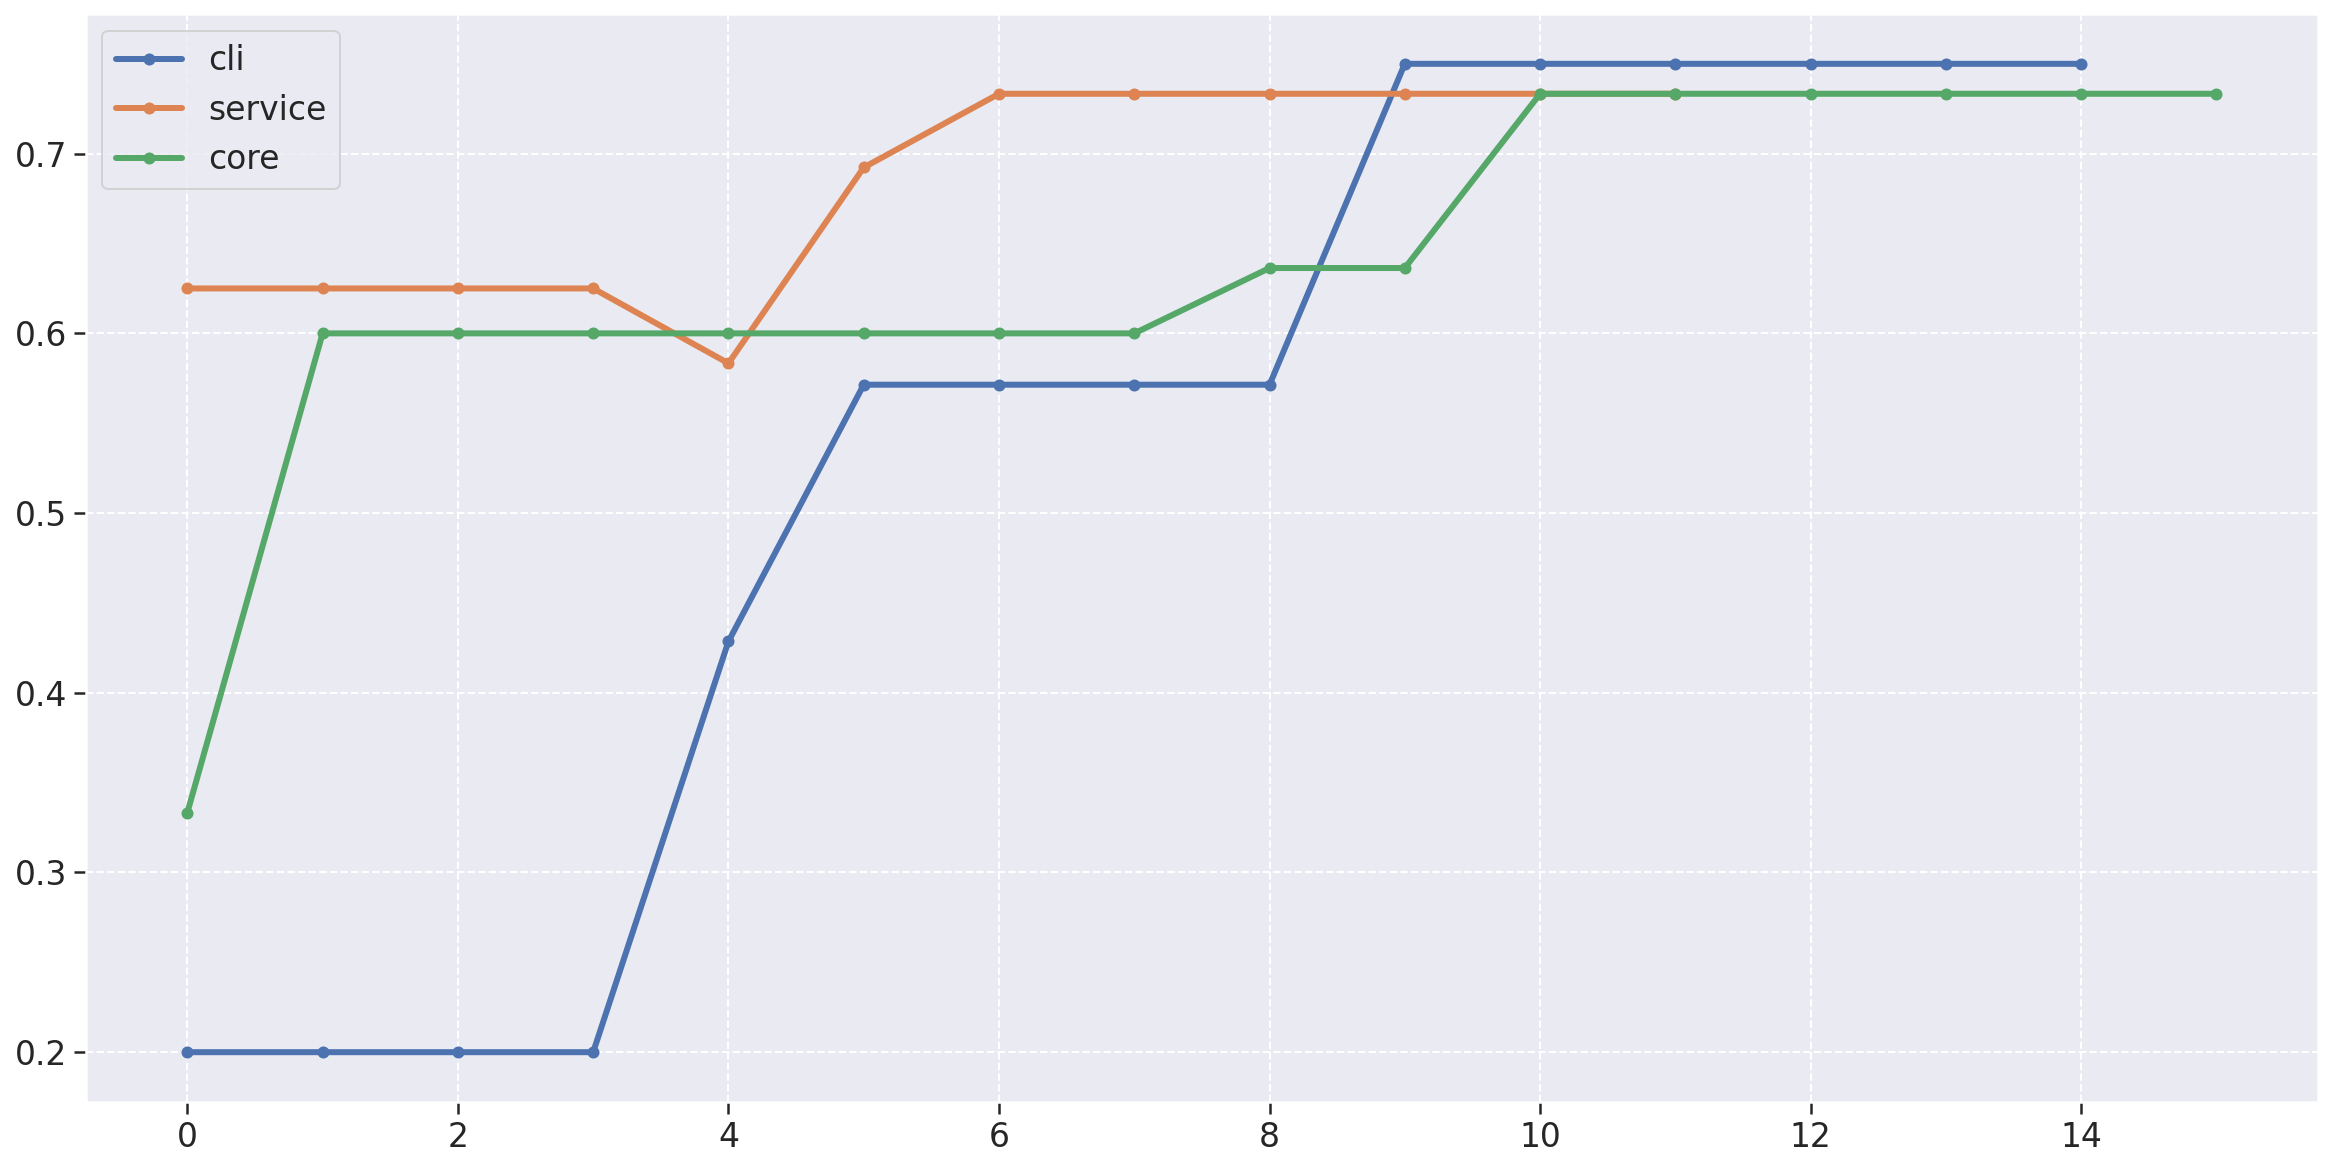

In [269]:
fig = plt.figure(figsize=(20, 10))


plt.plot(cli_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label="cli")
plt.plot(service_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label="service")
plt.plot(core_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label="core")

plt.legend(loc='best')



In [270]:
all_repos = [cli_metrics, service_metrics, core_metrics]

for repo in all_repos:
    repo['Maintainability'] = repo['code_quality']
    repo['Reliability'] = repo['testing_status']
    repo['Total_QR'] = repo['Maintainability']* pc1 + repo['Reliability']* pc2


In [271]:
# output metrics to csv

currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H-%M-%S")

for repo in all_repos:
    repo_name = repo["repository"].iloc[0]
    repo.to_excel(f'{repo_name}-{currentDateTime}.xlsx', index=False)
    repo.to_csv(f'{repo_name}-{currentDateTime}.csv', index=False)



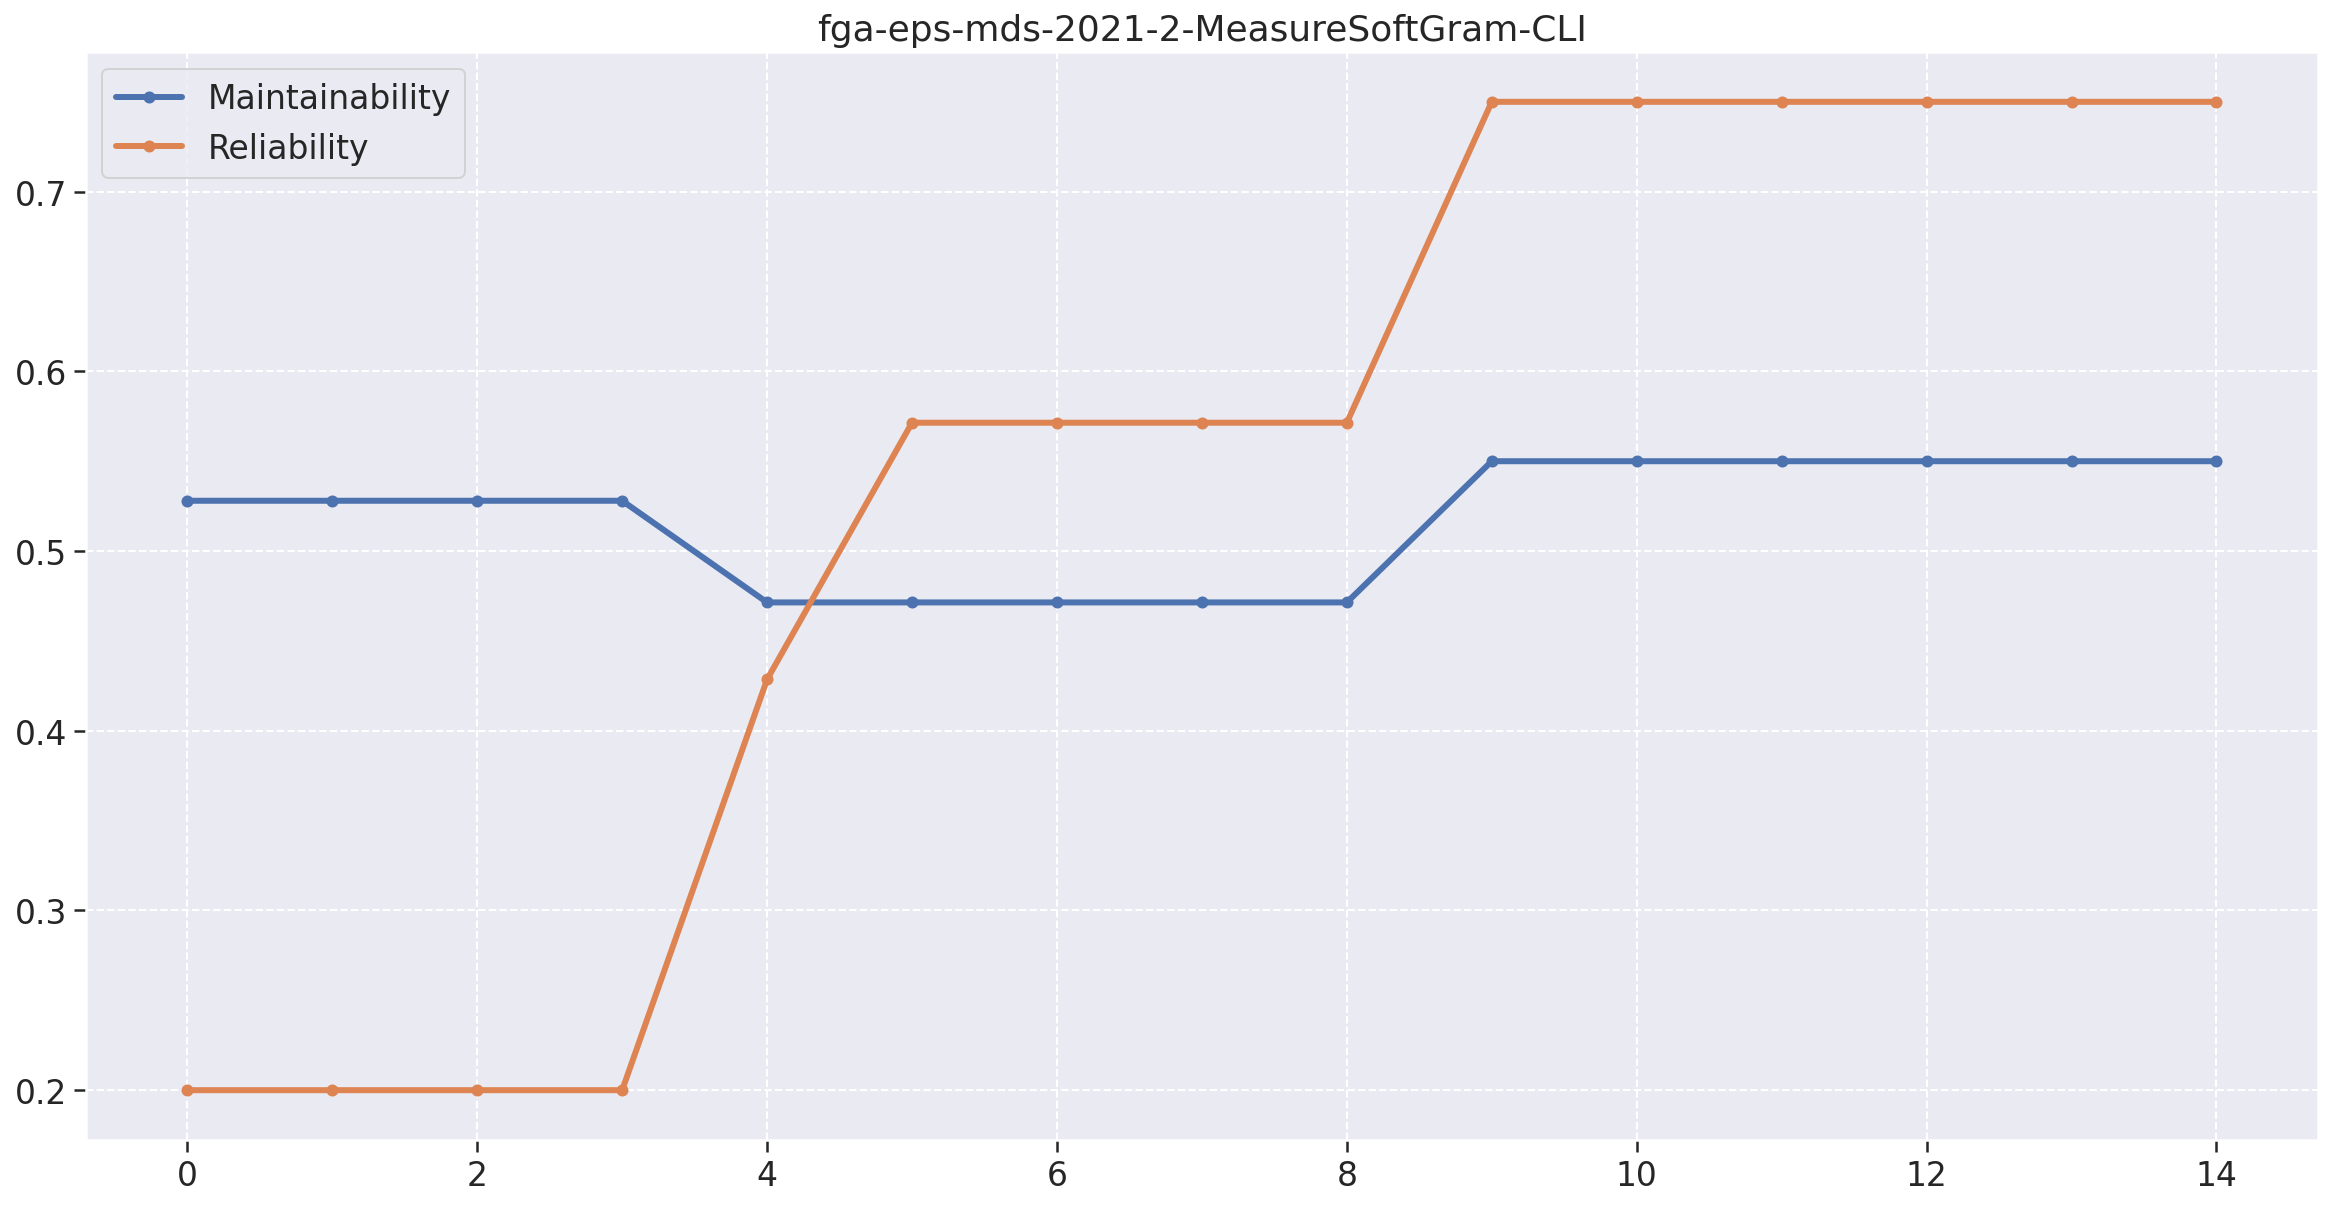

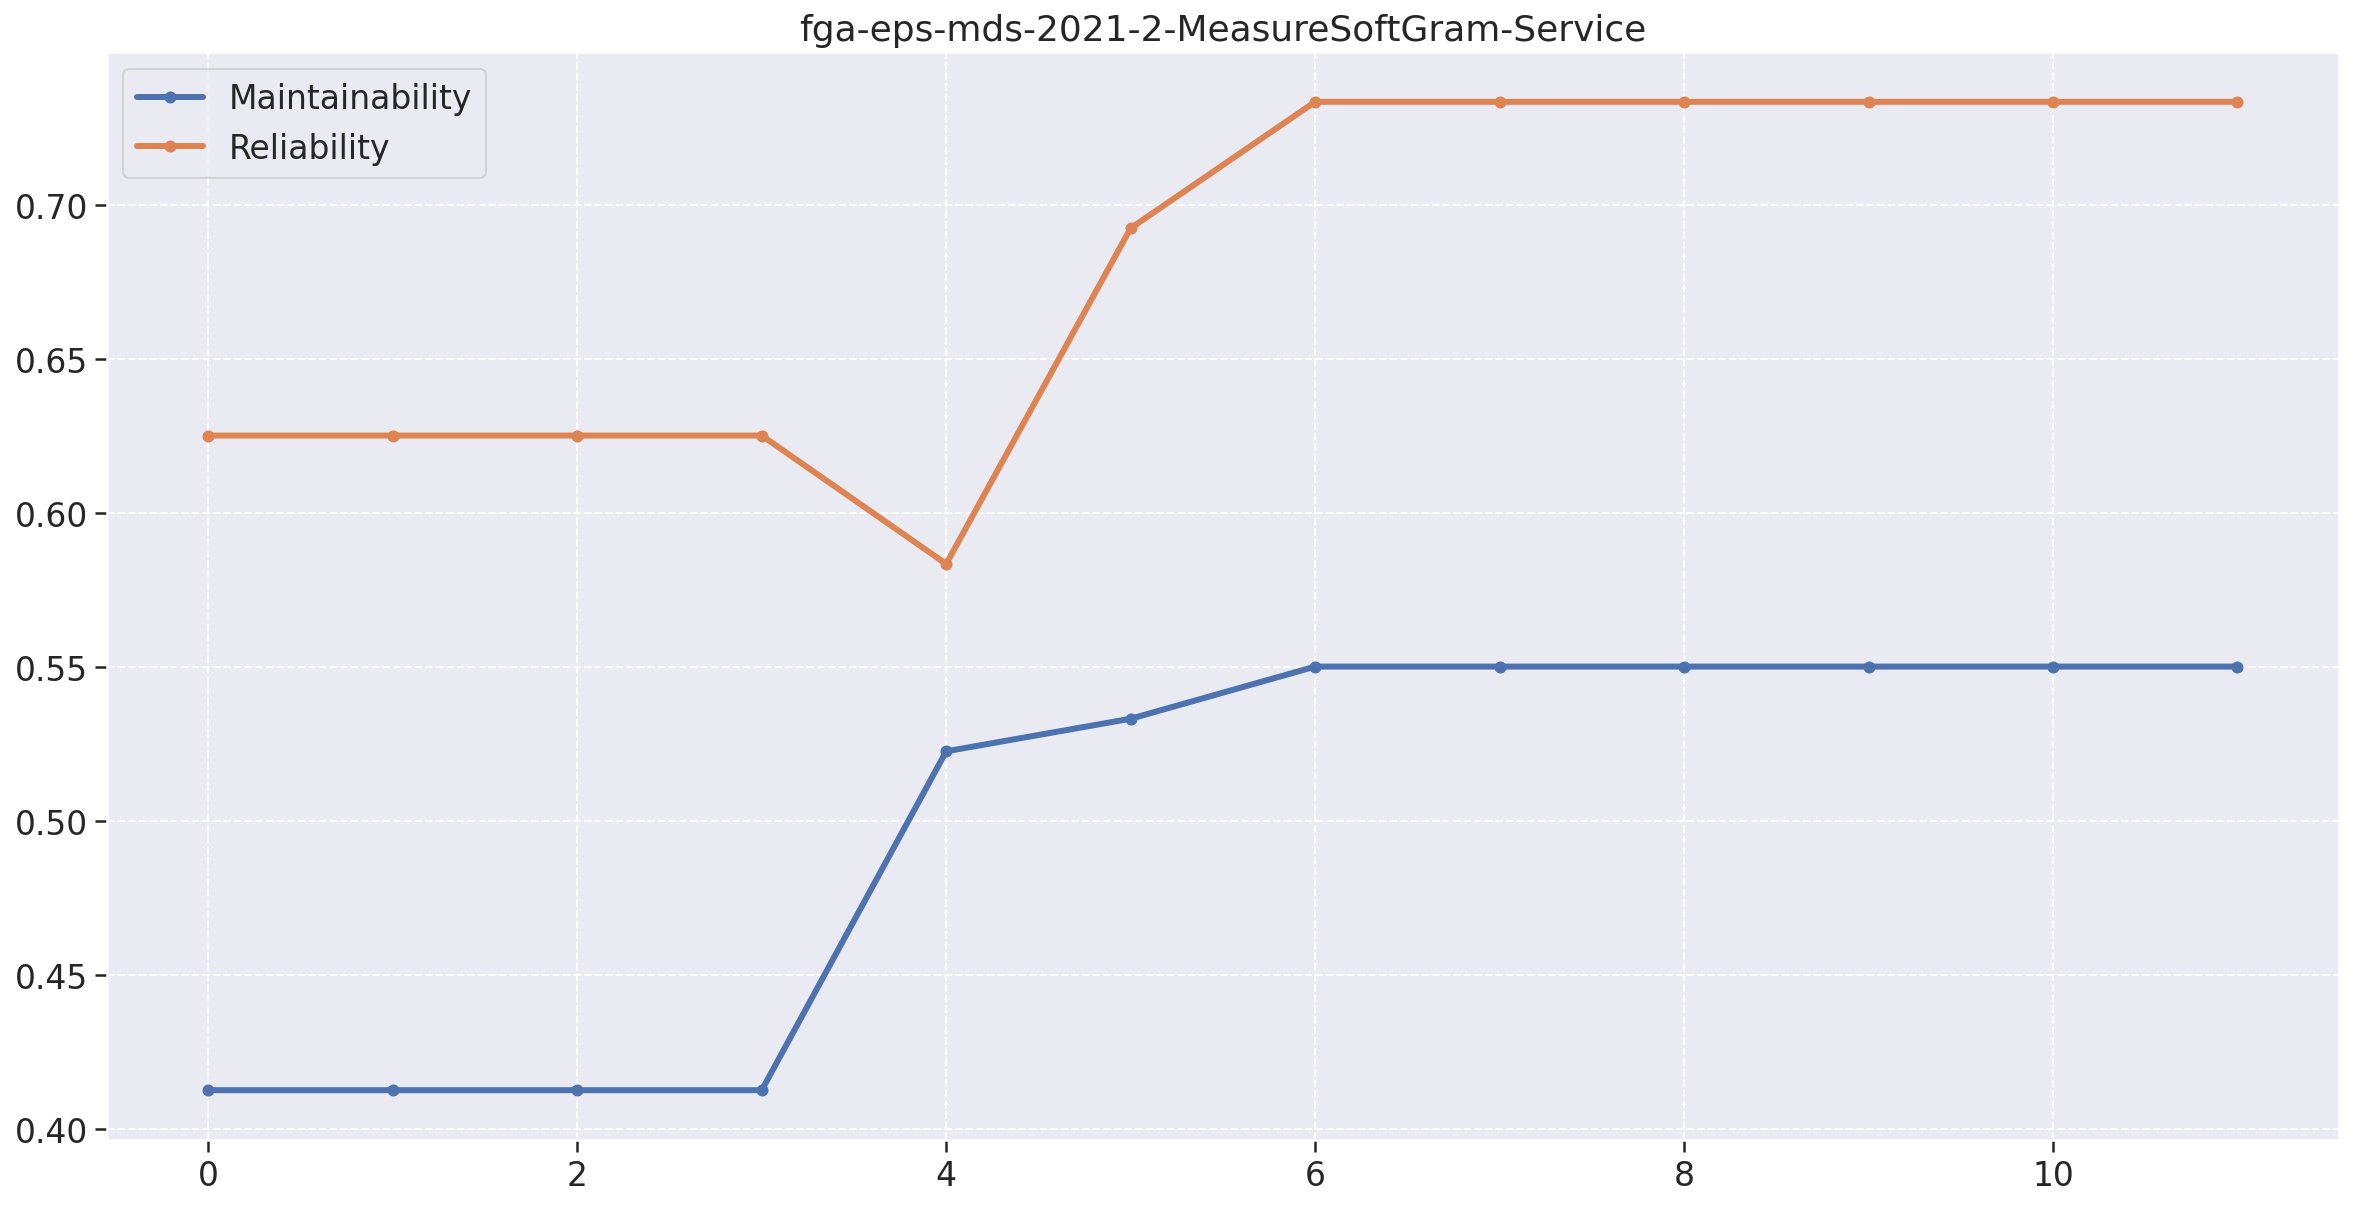

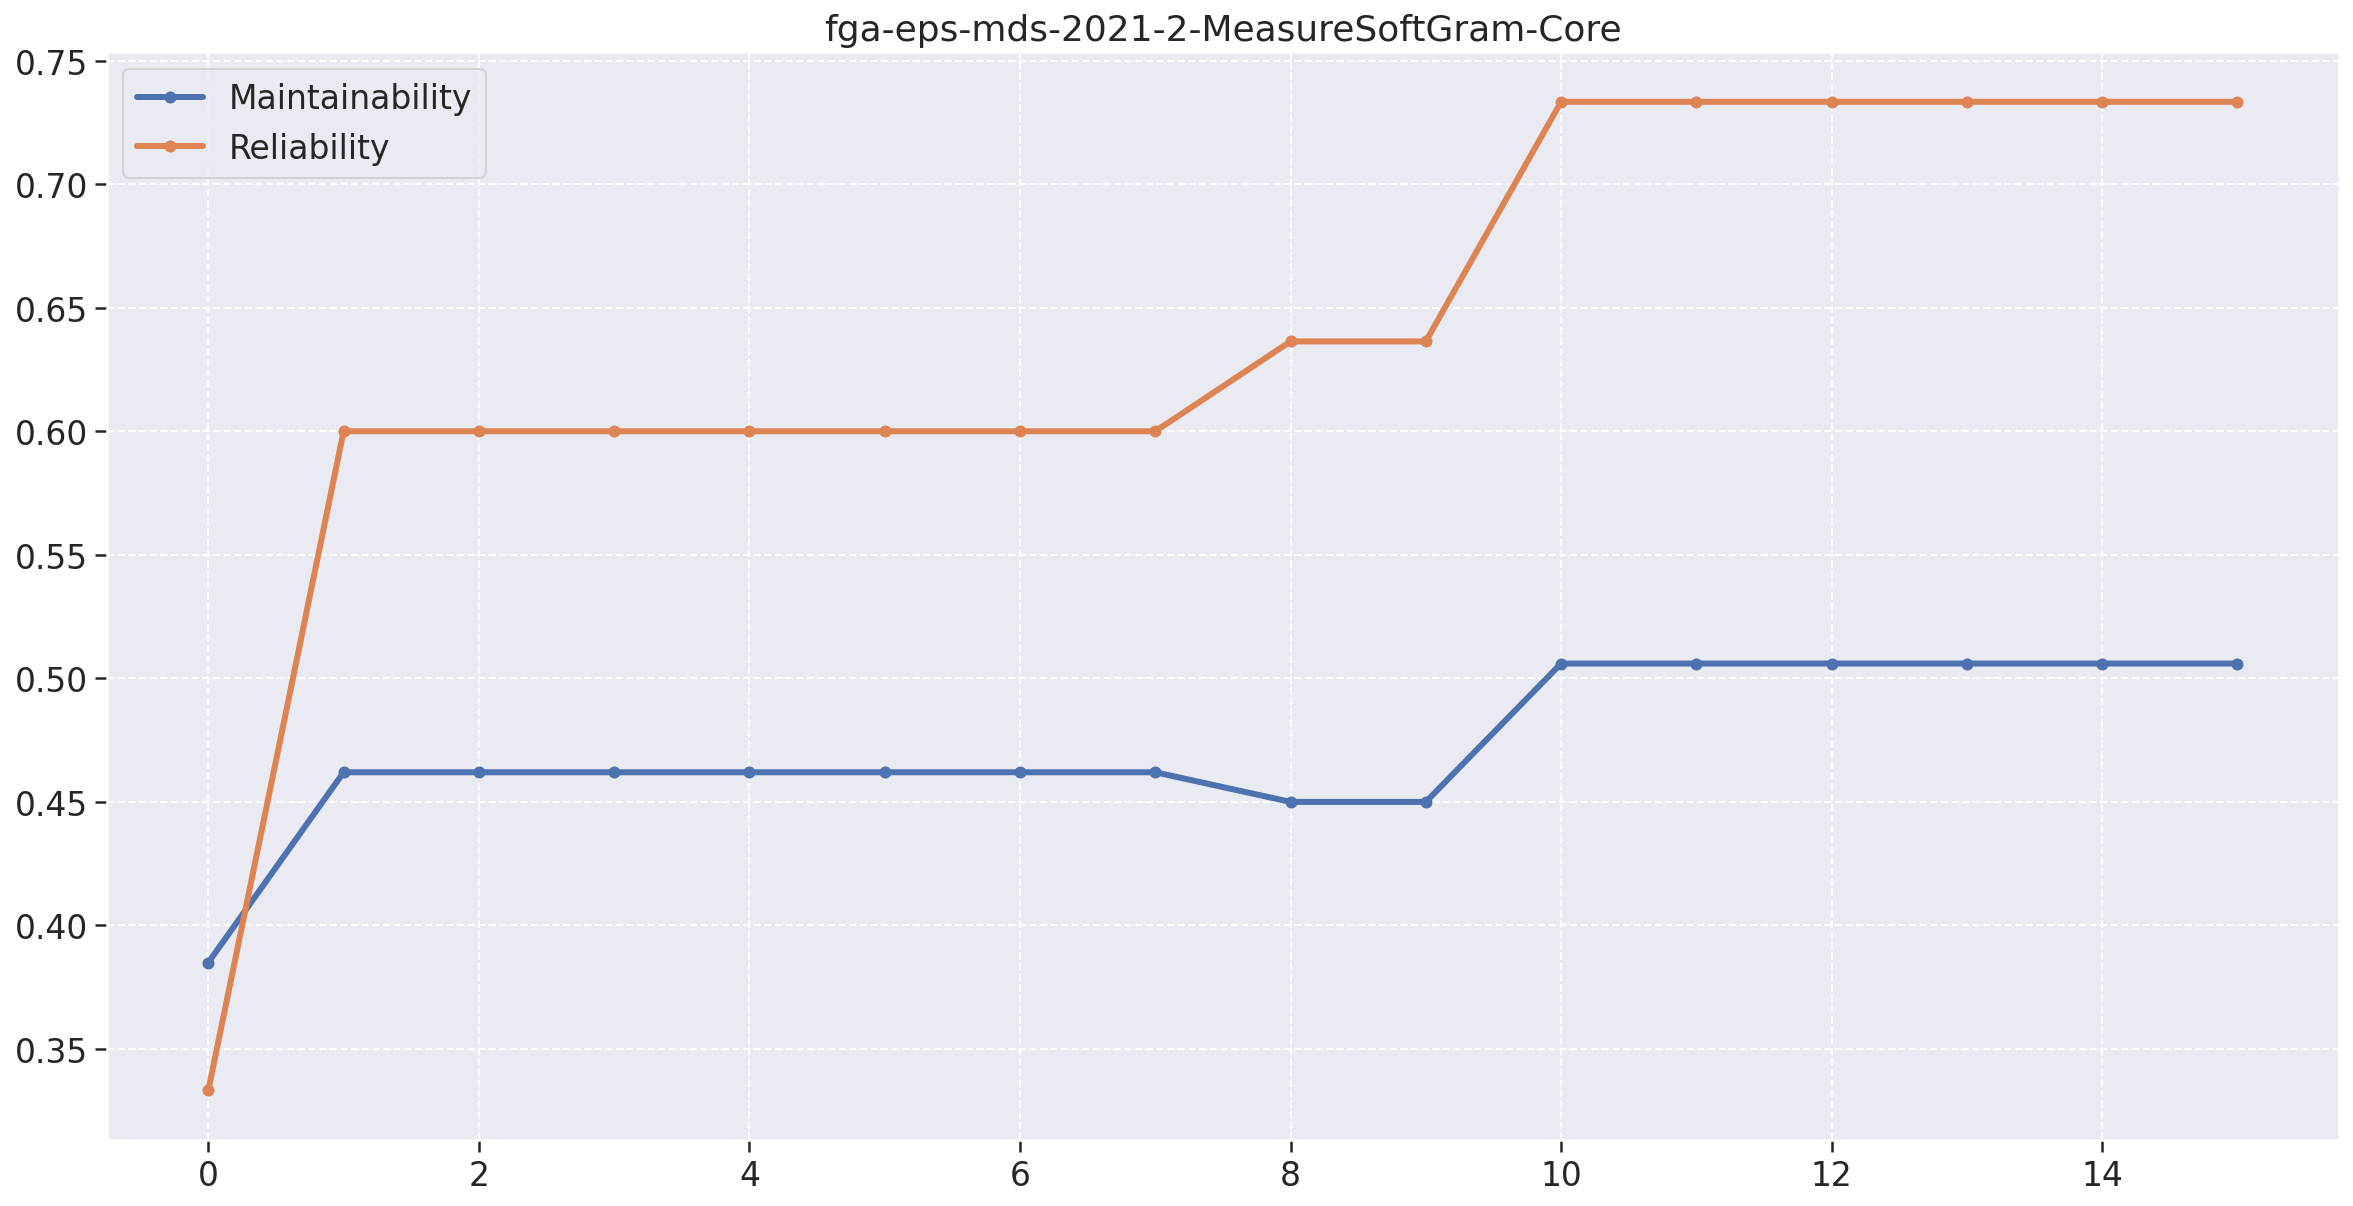

In [272]:
for repo in all_repos:
    fig = plt.figure(figsize=(20, 10))
    repo_name = repo["repository"].iloc[0]
    
    plt.title(f'{repo_name}')
    plt.plot(repo['Maintainability'], linewidth=3, marker='o', markersize=5, label="Maintainability")
    plt.plot(repo['Reliability'], linewidth=3, marker='o', markersize=5, label="Reliability")
    plt.legend(loc='best')



#plt.ylim(.45,.7)

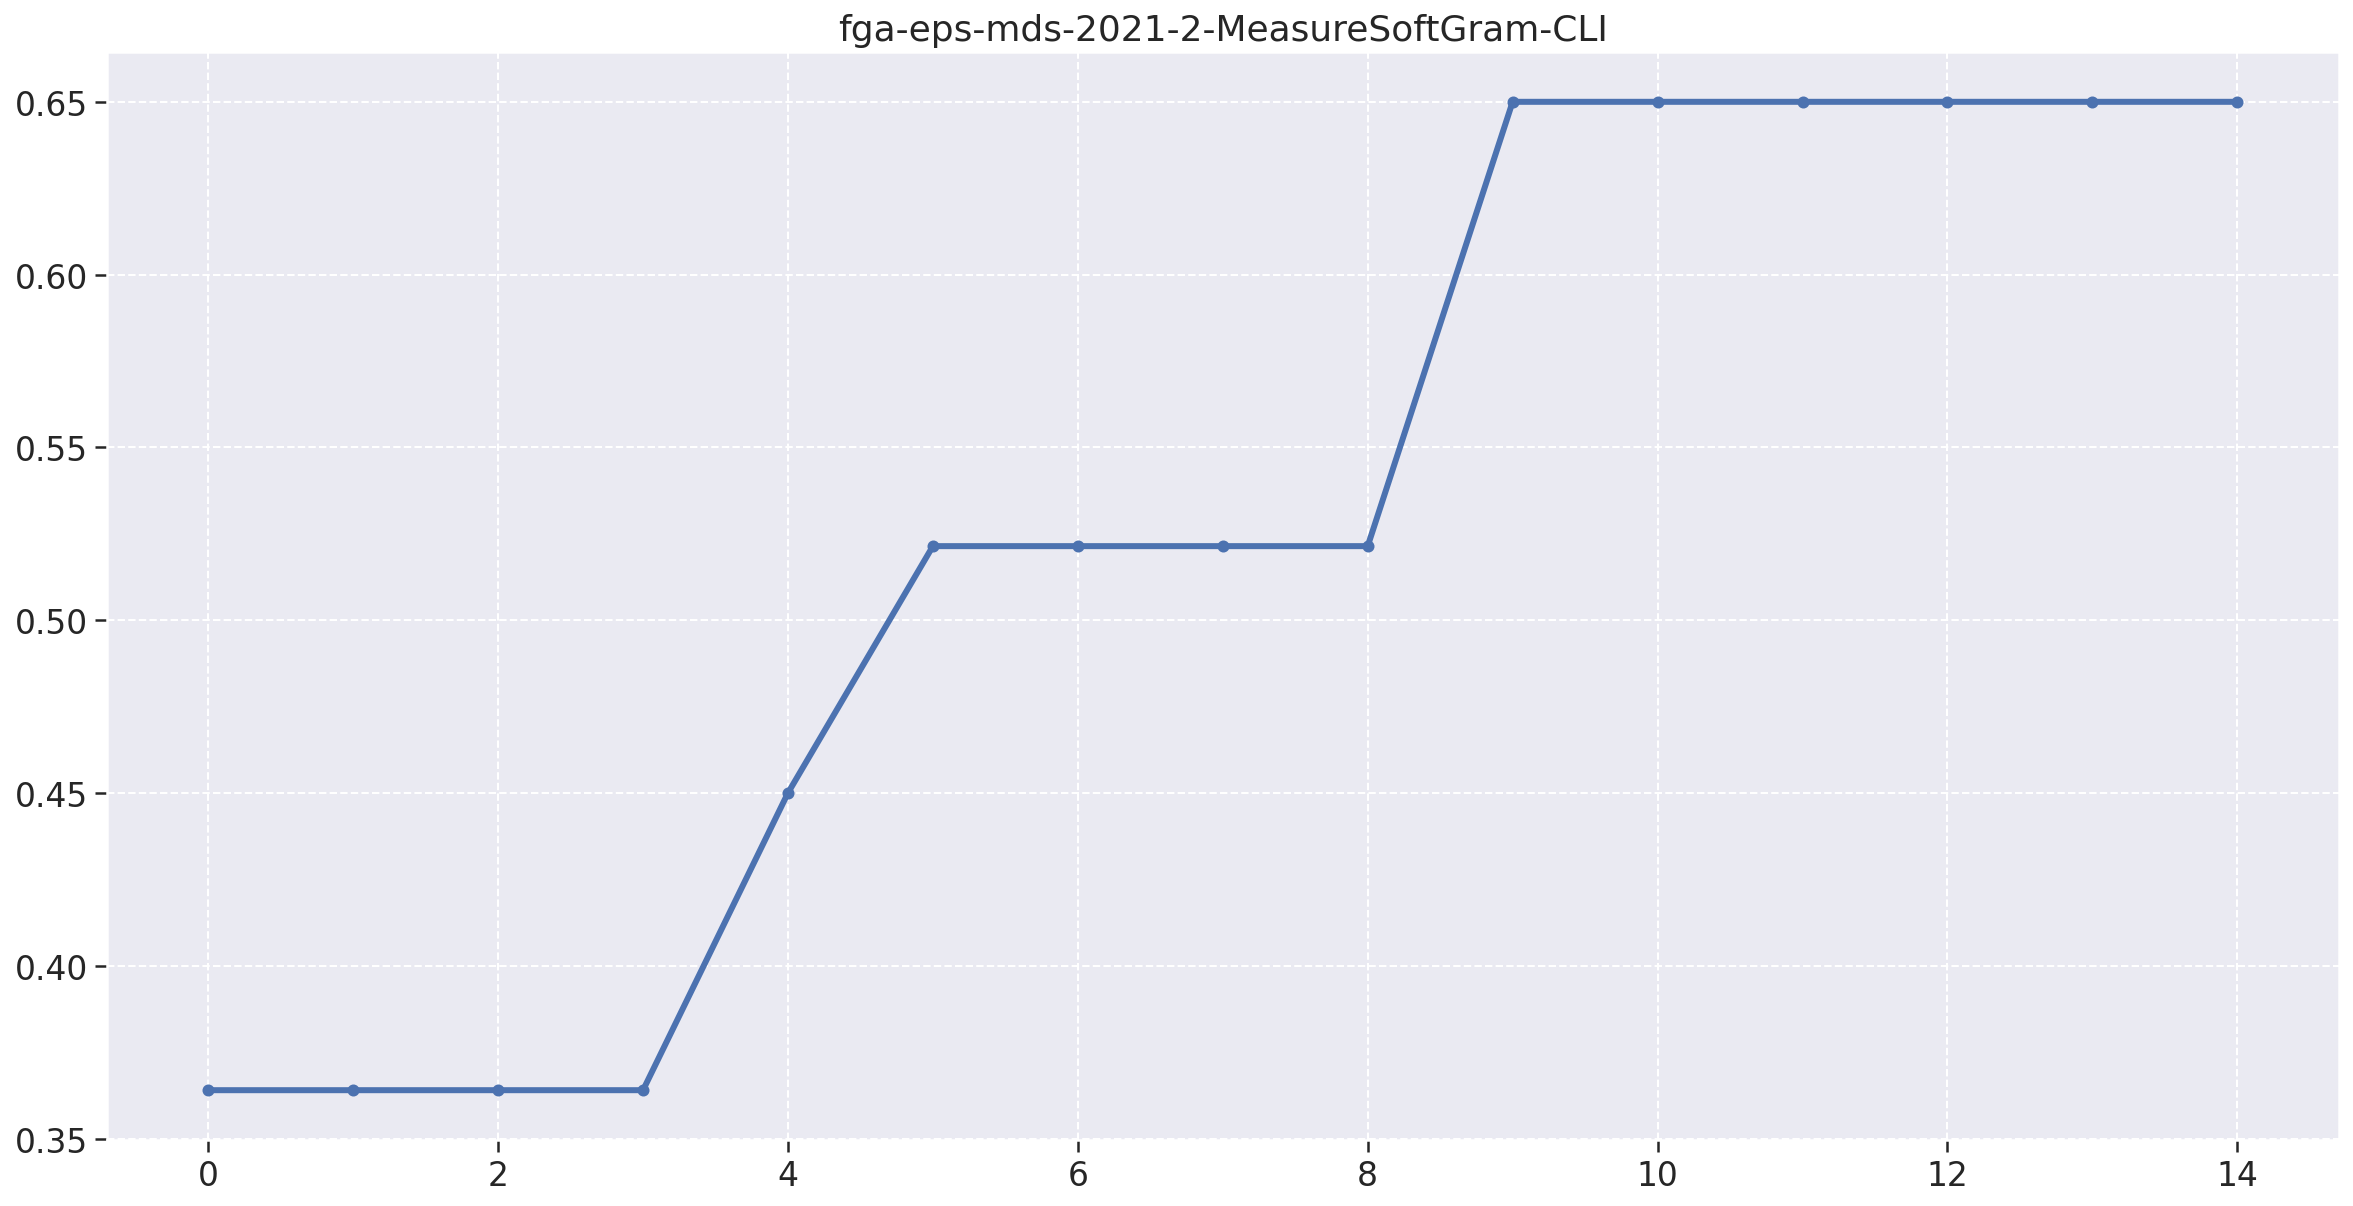

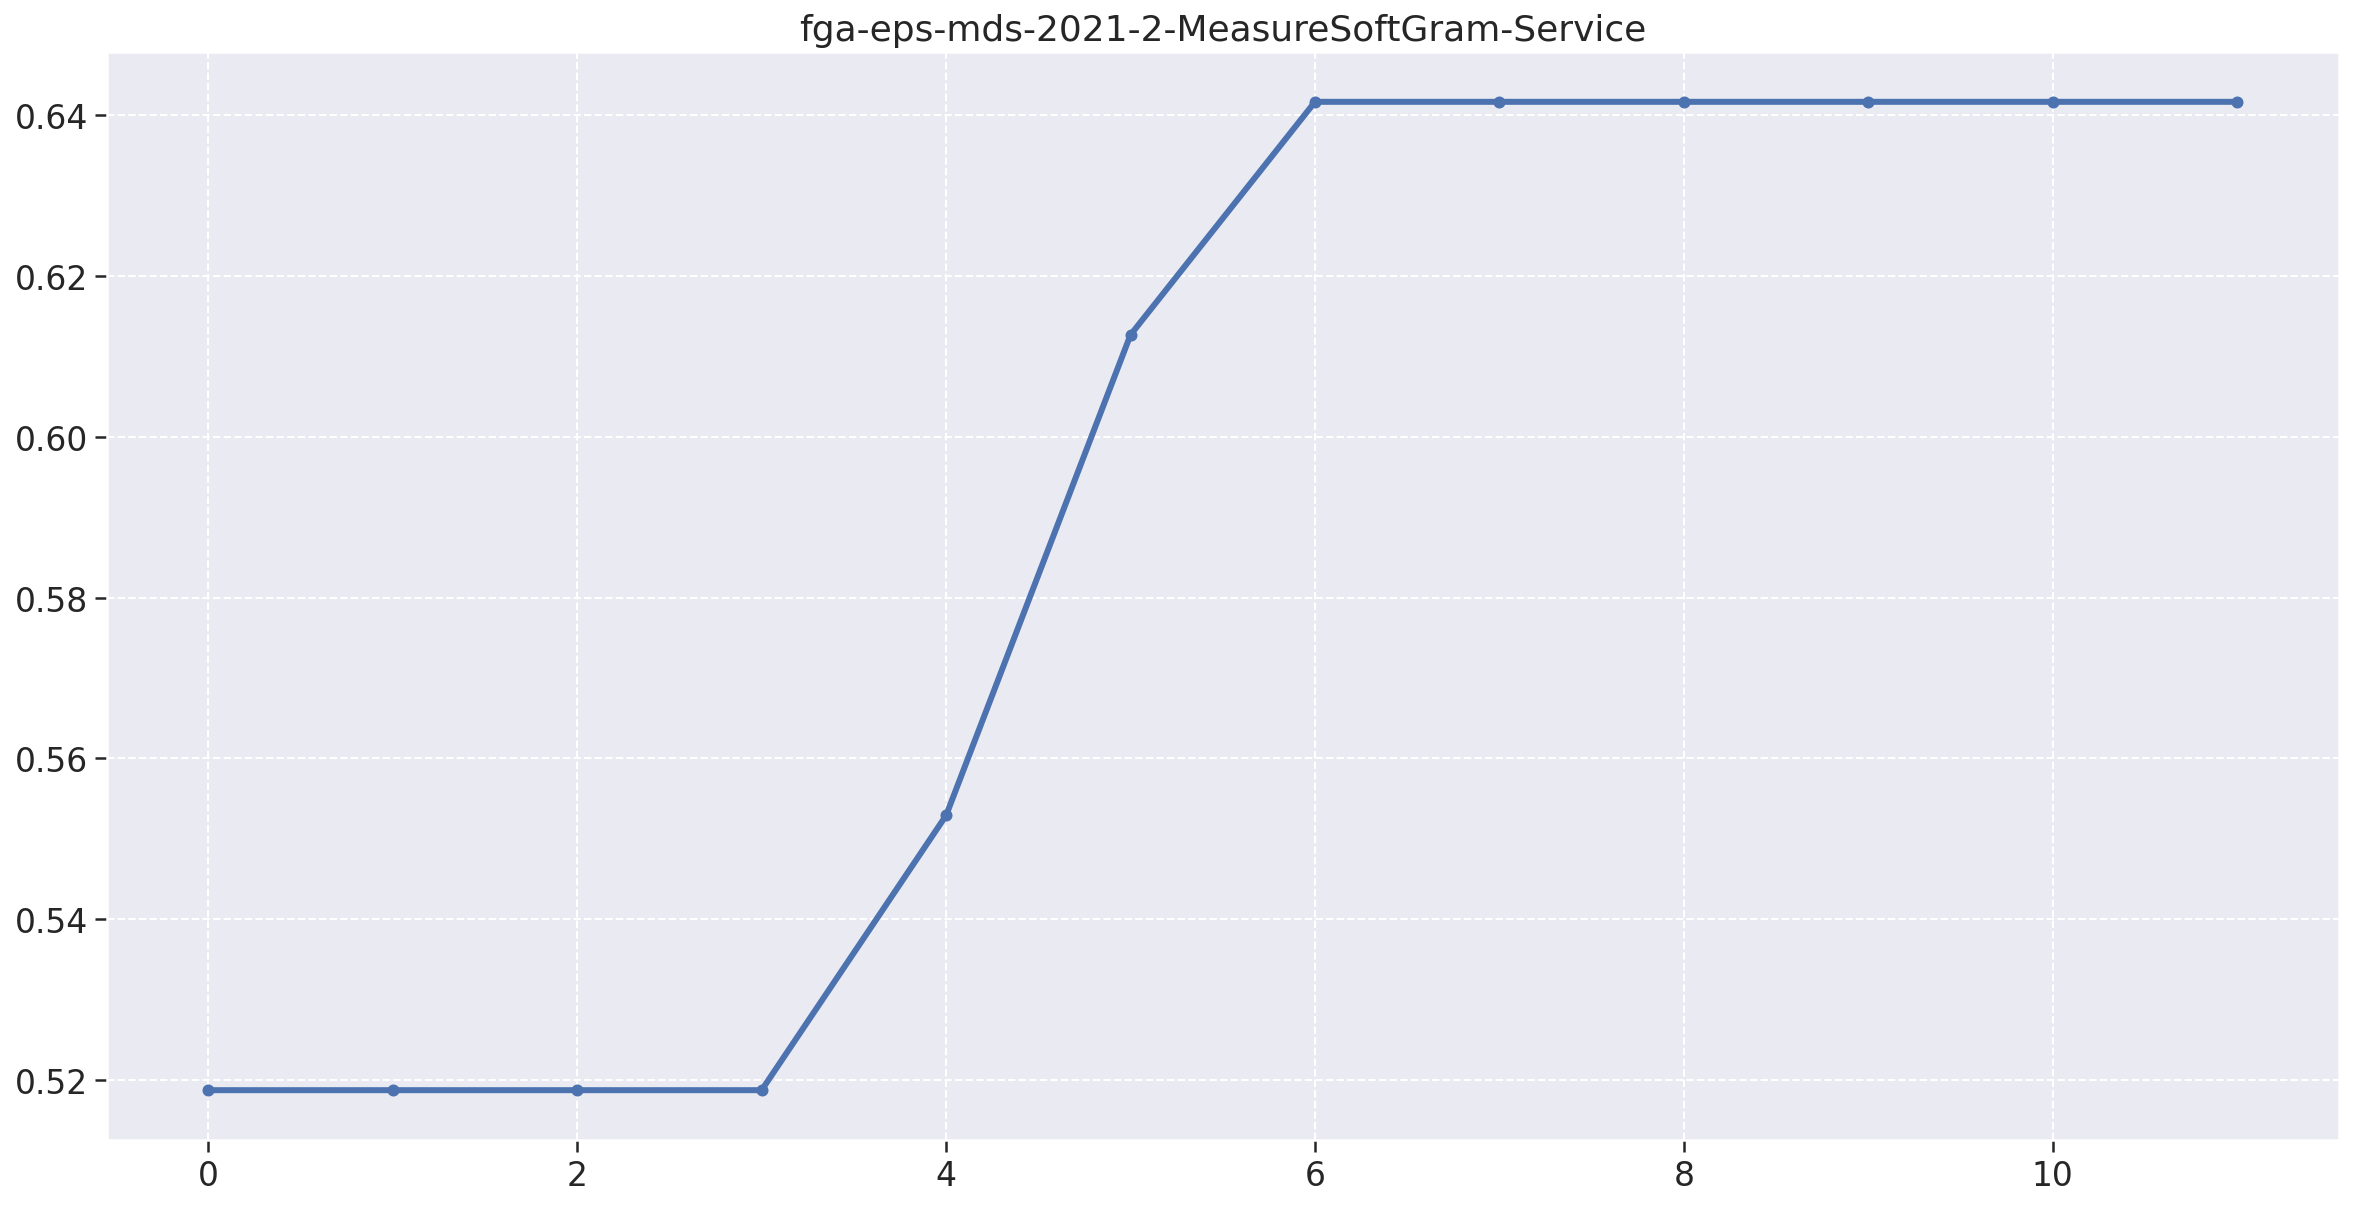

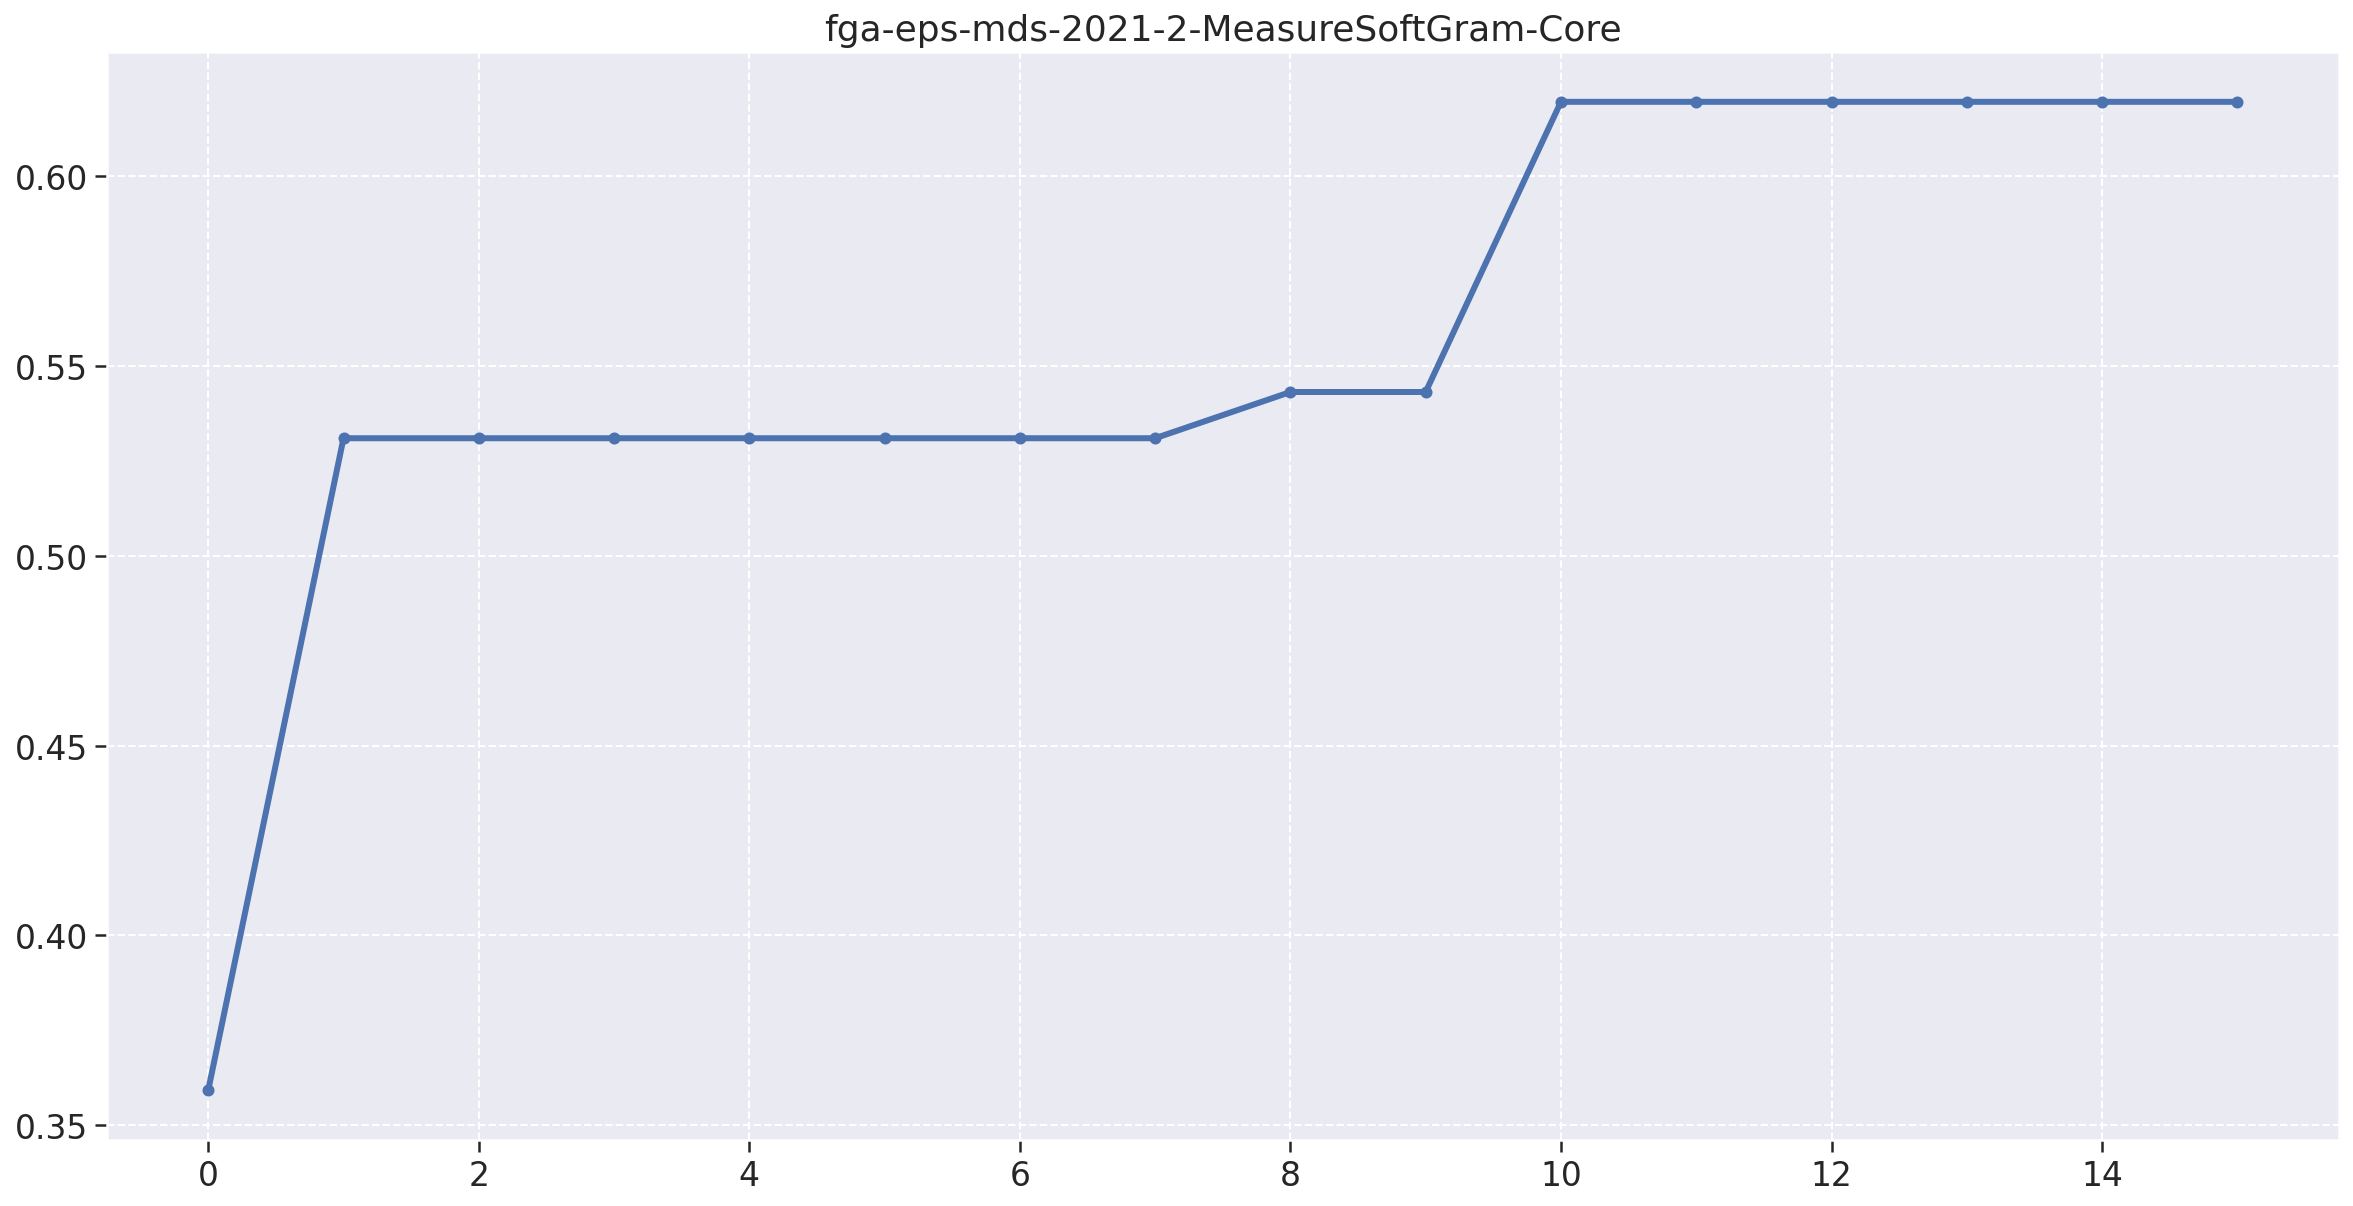

In [273]:


for repo in all_repos:
    fig = plt.figure(figsize=(20, 10))
    repo_name = repo["repository"].iloc[0]
    
    plt.title(f'{repo_name}')
    plt.plot(repo['Total_QR'], linewidth=3, marker='o', markersize=5)



In [274]:
# repo with more versions: core

# (média, moda, mediana, desvio padrão, variância, mínimo, máximo ) 
# para Maintainability e Reliability

current_repo = core_metrics

def get_char_stats(series):
    return {
        'mean': series.mean(),
        'mode': series.mode(),
        'median': series.median(),
        'std': series.std(),
        'var': series.var(),
        'min': series.min(),
        'max': series.max()
    }

maintainability_stats = pd.DataFrame(get_char_stats(current_repo["Maintainability"]), columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])
reliability_stats = pd.DataFrame(get_char_stats(current_repo["Reliability"]), columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])



In [275]:
print(maintainability_stats)
print(reliability_stats)

       mean   mode  median       std       var    min    max
0  0.472187  0.462   0.462  0.032835  0.001078  0.385  0.506
       mean  mode    median       std       var       min       max
0  0.637879   0.6  0.618182  0.102458  0.010498  0.333333  0.733333


{'whiskers': [<matplotlib.lines.Line2D at 0x7fcba3092d90>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcba30a0370>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcba3092be0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fcba30a0910>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fcba30a0be0>,
 'means': []}

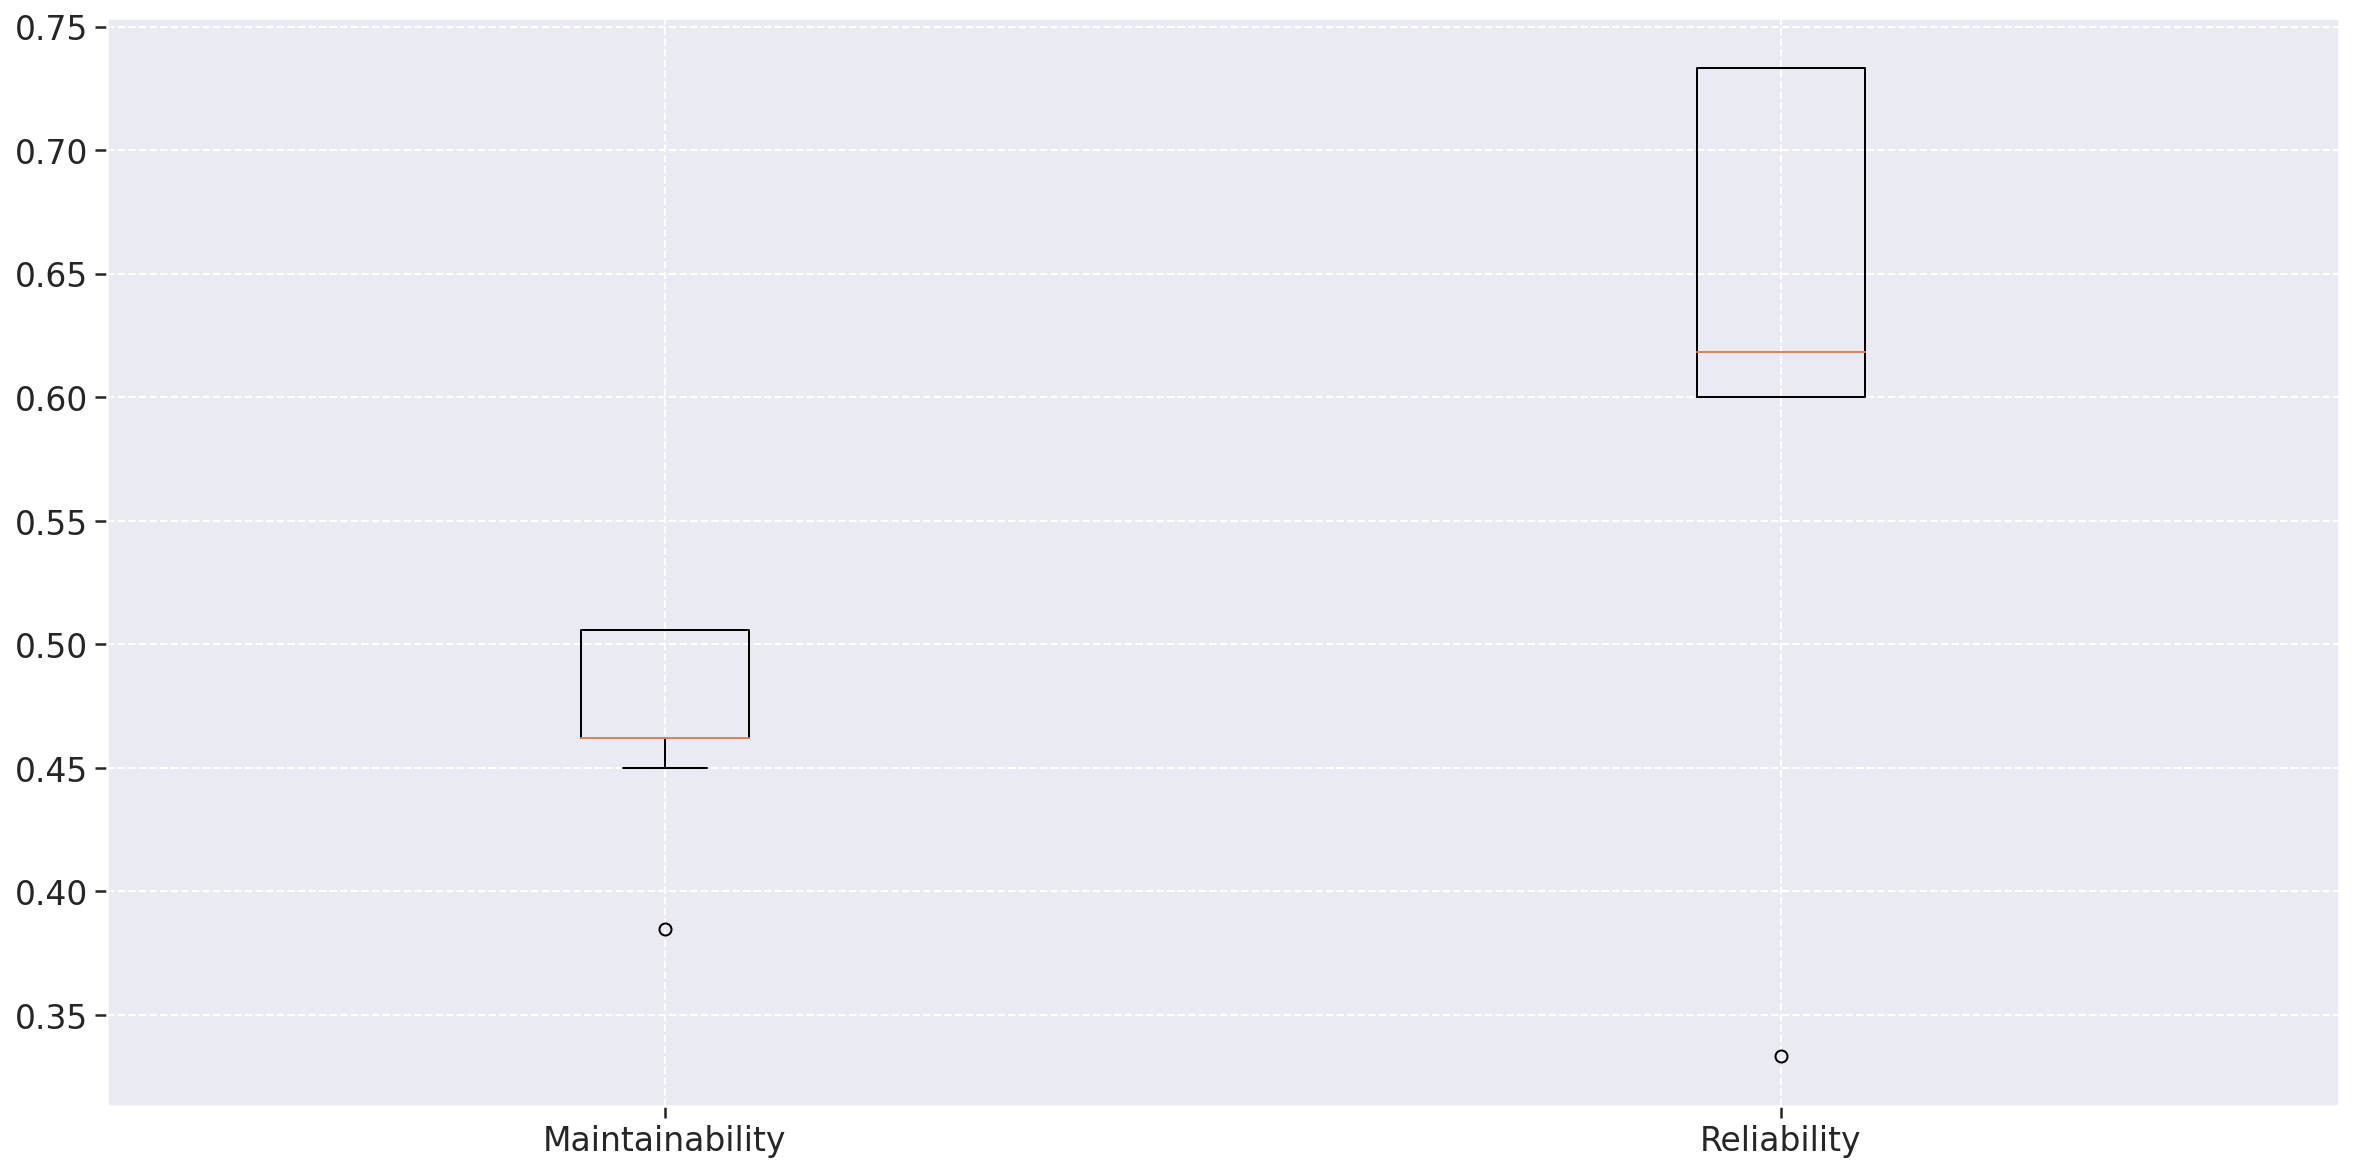

In [276]:
plt.figure(figsize=(20, 10))

# boxplot
plt.boxplot([current_repo['Maintainability'], current_repo['Reliability']], 
labels=['Maintainability', 'Reliability'])



O outlier que pode ser observado na Reliability acontece devido ao início do projeto onde não tínhamos testes implementados.

Já em relação à manutenibilidade, o outlier é decorrente do estado inicial do sistema. Um ponto a se observar é que menos de 20% dos arquivos eram não complexos. No geral, isso acontece com todas as métricas. Possivelmente, pode estar ocorrendo um problema de medição no Sonar.

In [277]:
product_df = pd.concat([cli_metrics, service_metrics, core_metrics], ignore_index=True)

product_df['Maintainability'] = product_df['code_quality'] * pc1
product_df['Reliability'] = product_df['testing_status'] * pc2
product_df['Total_QR'] = product_df['Maintainability'] + product_df['Reliability']

product_df = product_df.sort_values(by=['version'])
product_df = product_df.reset_index(drop=True)

In [278]:
product_df

,m1,m2,m3,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,Total_QR
0,0.600000,0.000000,1.0,0.200000,fga-eps-mds-2021-2-MeasureSoftGram-CLI,1.0.0,331,0.528000,0.200000,0.264000,0.100000,0.364000
1,0.250000,0.000000,1.0,0.625000,fga-eps-mds-2021-2-MeasureSoftGram-Service,1.0.0,47,0.412500,0.625000,0.206250,0.312500,0.518750
2,0.166667,0.000000,1.0,0.333333,fga-eps-mds-2021-2-MeasureSoftGram-Core,1.0.0,11,0.385000,0.333333,0.192500,0.166667,0.359167
3,0.250000,0.000000,1.0,0.625000,fga-eps-mds-2021-2-MeasureSoftGram-Service,1.0.1,46,0.412500,0.625000,0.206250,0.312500,0.518750
4,0.600000,0.000000,1.0,0.200000,fga-eps-mds-2021-2-MeasureSoftGram-CLI,1.0.1,349,0.528000,0.200000,0.264000,0.100000,0.364000
5,0.300000,0.100000,1.0,0.600000,fga-eps-mds-2021-2-MeasureSoftGram-Core,1.0.1,128,0.462000,0.600000,0.231000,0.300000,0.531000
6,0.300000,0.100000,1.0,0.600000,fga-eps-mds-2021-2-MeasureSoftGram-Core,1.0.2,128,0.462000,0.600000,0.231000,0.300000,0.531000
7,0.250000,0.000000,1.0,0.625000,fga-eps-mds-2021-2-MeasureSoftGram-Service,1.0.2,46,0.412500,0.625000,0.206250,0.312500,0.518750
8,0.600000,0.000000,1.0,0.200000,fga-eps-mds-2021-2-MeasureSoftGram-CLI,1.0.2,349,0.528000,0.200000,0.264000,0.100000,0.364000
9,0.600000,0.000000,1.0,0.200000,fga-eps-mds-2021-2-MeasureSoftGram-CLI,1.0.3,349,0.528000,0.200000,0.264000,0.100000,0.364000


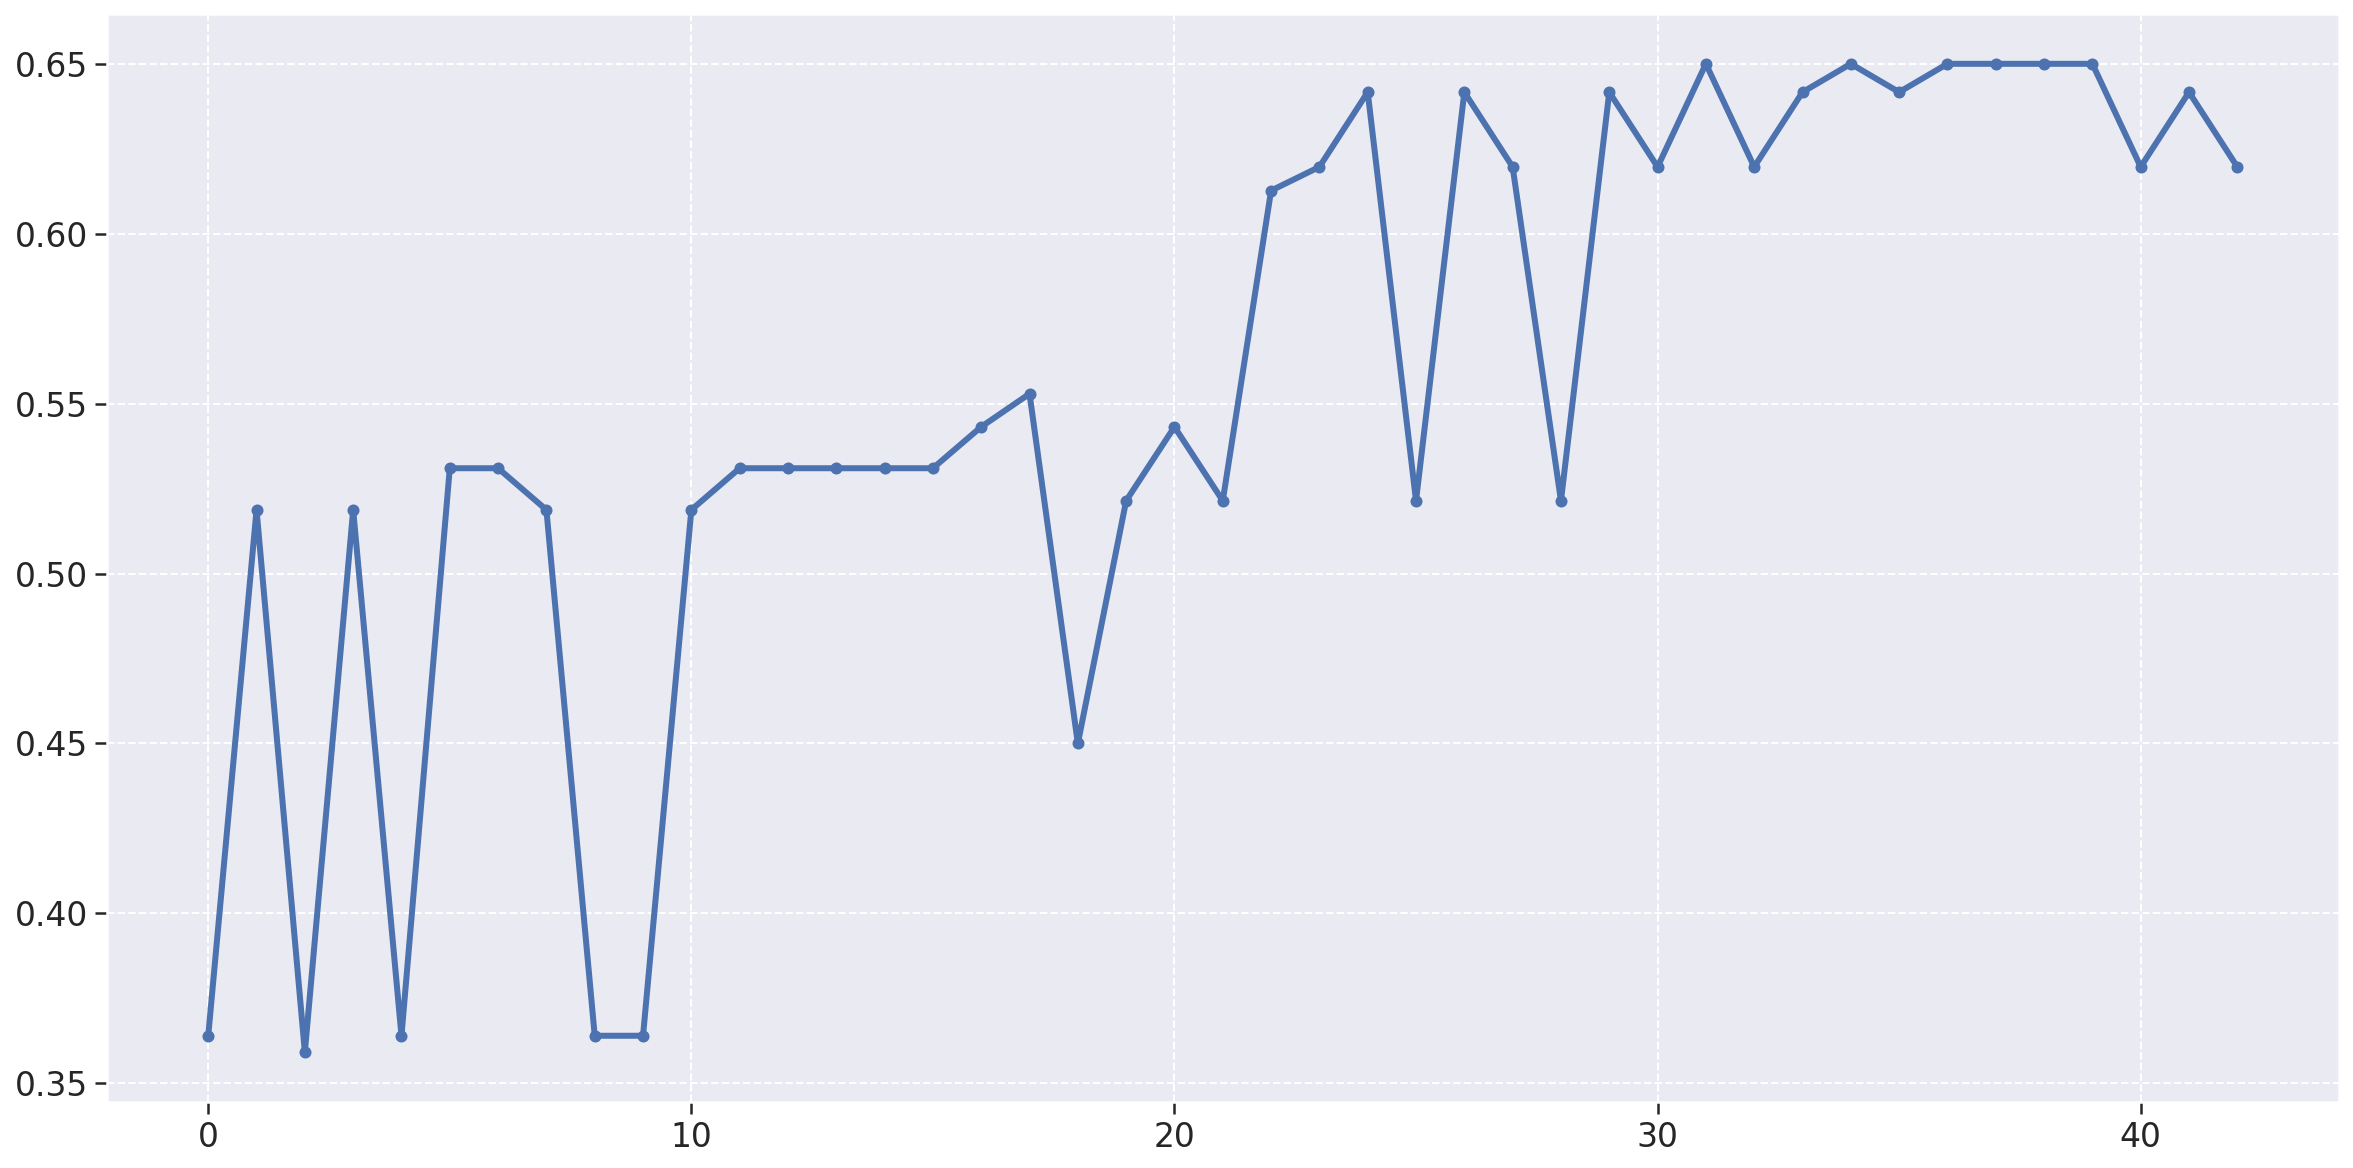

In [279]:
fig = plt.figure(figsize=(20, 10))


plt.plot(product_df['Total_QR'], linewidth=3, marker='o', markersize=5)

Na visão do time, agregar os diferentes componentes do sistema não fez sentido, visto que são subsistemas com características extremamente diferentes. No entanto, é observado um crescimento da qualidade total do produto com o passar do tempo. 

De maneira semelhante, o time tem suas dúvidas em relação à métrica avaliada (densidade de arquivos comentados). Entendemos que o peso dessa métrica deveria ser menor, visto que ao nosso ver, 10% de comentários por arquivo é um número muito alto.